<a href="https://colab.research.google.com/github/ronyates47/Gedcom-Utils/blob/main/A_06_11_Library_stable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas
!pip install python-gedcom
!pip install openpyxl
!pip install xlsxwriter


In [ ]:
# defined_names

import pandas as pd
import re

# Load the Excel file
file_path = '/content/DNA_Study_Library.xlsx'  # Update this path as needed
data = pd.read_excel(file_path, sheet_name='DNA_Study_Library')

# Extract unique First Pair names
unique_first_pairs = data['First Pair'].unique()

# Function to split the First Pair and extract names
def split_first_pair(pair):
    parent1, parent2 = pair.split('&')
    parent1_name = ''.join([i for i in parent1 if not i.isdigit()])  # Remove digits from name
    parent2_name = ''.join([i for i in parent2 if not i.isdigit()])
    return parent1_name, parent2_name

# Function to format names in "firstname lastname" order
def format_name(name):
    if 'Yates' in name:
        parts = name.split('Yates')
        if len(parts) == 2:
            lastname = 'Yates'
            firstname = parts[1]
            formatted_name = f"{firstname.capitalize()} {lastname.capitalize()}"
        else:
            formatted_name = name
    else:
        # Handle non-Yates names
        parts = re.findall('[A-Z][^A-Z]*', name)  # Split by uppercase letters
        if len(parts) > 1:
            lastname = parts[0]
            firstname = ' '.join(parts[1:])
            formatted_name = f"{firstname.capitalize()} {lastname.capitalize()}"
        else:
            formatted_name = name.capitalize()  # If the pattern doesn't match, return the name as is

    return formatted_name

# Process each unique First Pair
report_data = []
for pair in unique_first_pairs:
    parent1_name, parent2_name = split_first_pair(pair)
    parent1_name_fl = format_name(parent1_name)
    parent2_name_fl = format_name(parent2_name)
    report_data.append({'First Pair': pair,
                        'Parent 1': parent1_name_fl,
                        'Parent 2': parent2_name_fl})

# Create DataFrame for the report
report_df_fl = pd.DataFrame(report_data)

# Save the report to an Excel file
output_excel_path = '/content/defined_names.xlsx'
report_df_fl.to_excel(output_excel_path, index=False)

# Provide a link to download the file in Colab
from google.colab import files
files.download(output_excel_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Table of Contents

- [Section 1: Main Script](#section-1a-main script-html_output)
- [Section 1: Main Script](#section-1b-main script-parsing & libraries)
- [Section 2: Data Cleaning](#section-2-root_parent_processed_list)
- [Section 3: Data Analysis](#section-3-root_parent_for_chart)
- [Section 4: Data Visualization](#section-4-parents&offspring_chart)
- [Section 5: Model Training](#section-5-Make_Parents_Trailing_Descendants)
- [Section 6: Model Evaluation](#section-6-Draft_Graph)
- [Section 7: Chart of First Parents and Sort Names]
- [Section 8: Chart of Sort Name and First Parents]
- [Section 9: Matrix-2_Sort Name and First Parents]
-[Section 10: Matrix-2_Sort Name and First Parents.xlsx]
-[Section 11: 31YatesAbraham&42SearchingStill]


In [ ]:
#section-1a-main script-html_output

import csv
import glob
from gedcom.element.individual import IndividualElement
from gedcom.parser import Parser
import pandas as pd

anchor_gen1 = None

class GedcomDataset:
    def __init__(self, gen_person):
        self.gen_person = gen_person
        self.extractable_detail = {}
        self.anchor_gen1 = None  # Initialize anchor_gen1 here

    def add_extractable_detail(self, key, value):
        self.extractable_detail[key] = value

    def get_gen_person(self):
        name = self.extractable_detail.get('NAME', '')
        parts = name.split('/', 1)
        first_name = parts[0].split(' ')[0]
        last_name = parts[1].rstrip('/') if len(parts) > 1 else ""
        self.anchor_gen1 = last_name.replace(" ", "") + first_name.replace(" ", "")
        global anchor_gen1  # Declare that we're using the global variable
        anchor_gen1 = self.anchor_gen1  # Update the global variable
        return self.gen_person.strip('@')

    def get_anchor_gen1(self):
        return self.anchor_gen1

    def get_extractable_NPFX(self):
        return self.extractable_detail.get('NPFX', '')

    def get_extractable_cm(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            cm_value = npfx_value.split('&')[0].strip()
        else:
            cm_value = npfx_value.strip()
        try:
            int(cm_value)
            return cm_value
        except ValueError:
            return 'error'

    def get_extractable_sort(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            sort_value = npfx_value.split('&')[1].strip()
            return sort_value
        else:
            return ''

    def get_extractable_FAMC(self):
        return self.extractable_detail.get('FAMC', '').strip('@')

# Function definitions
def extract_id(record):
    id_start = record.find('@') + 1
    id_end = record.find('@', id_start)
    return record[id_start:id_end]


def extract_name(record):
    name_start = record.find('1 NAME ') + 6
    name_end = record.find('\n', name_start)
    name = record[name_start:name_end]
    first_name, last_name = name.split('/', 1)
    first_name = first_name[:10] # Use slicing syntax to extract the first 10 characters of the first_name variable
    last_name = last_name[:10].rstrip('/') # Use slicing syntax to extract the first 10 characters of the last_name variable
    return last_name.replace(" ", "") + first_name.replace(" ", "")

name_to_id = {}   # Global dictionary to hold name to ID mapping

class Gedcom:
    def __init__(self, file_name):
        self.file_name = file_name
        self.gedcom_datasets = []
        self.filter_pool = []

    @staticmethod
    def get_standard_name(file_path):
        file_name = file_path.split('/')[-1]
        if '.' in file_name:
            file_name = file_name.rsplit('.', 1)[0]
        standard_name = file_name.replace(' ', '_').lower()
        return standard_name

#class Gedcom:
#    def __init__(self, file_name):
#        self.file_name = file_name
#        self.gedcom_datasets = []
#        self.filter_pool = []

    def parse_gedcom(self):
        global name_to_id  # Declare name_to_id as global to modify it
        with open(self.file_name, 'r', encoding='utf-8-sig') as f:
            gedcom_lines = f.readlines()
        current_dataset = None
        npfx_count = 0
        total_count = 0

        for line in gedcom_lines:
            parts = line.strip().split(' ', 2)
            level = int(parts[0])
            tag = parts[1]
            value = parts[2] if len(parts) > 2 else None

            if level == 0 and tag.startswith('@') and tag.endswith('@') and value == 'INDI':
                total_count += 1
                current_dataset = GedcomDataset(tag)
                self.gedcom_datasets.append(current_dataset)

                # Populate name_to_id
                individual_name = current_dataset.get_anchor_gen1()
                individual_id = current_dataset.get_gen_person()
                name_to_id[individual_name] = individual_id

            elif current_dataset is not None:
                if level == 1 and tag in ['NAME', 'FAMC']:
                    current_key = tag
                    current_dataset.add_extractable_detail(current_key, value)

                elif level == 2 and tag == 'NPFX':
                    npfx_count += 1
                    current_dataset.add_extractable_detail(tag, value)

        print(f'GEDCOM contained {total_count} total records')
        print(f'Records tagged and filtered by NPFX: {npfx_count}')

        # First level of filtering: Filter those with NPFX
        for dataset in self.gedcom_datasets:
            if dataset.get_extractable_NPFX():
                self.filter_pool.append(dataset)

        # Check if manual filtering should be applied
        manual_filter_activated = True  # or False depending on your situation

        # Second level of filtering: Apply manual filter from Excel sheet
        if manual_filter_activated:
            import pandas as pd  # Assuming you haven't imported it yet
            try:
                df = pd.read_excel('filtered_ids.xlsx')
            except FileNotFoundError:
                print("filtered_ids.xlsx not found. Skipping second-level manual filter.")
            else:
                manual_filtered_ids = set(df['ID'])
                print(f"Manual filter IDs loaded: {len(manual_filtered_ids) - 1}")

                self.filter_pool = [dataset for dataset in self.filter_pool if dataset.get_gen_person() in manual_filtered_ids]
                print(f"After manual filter, total records: {len(self.filter_pool)}")

def input_prime_surname(last_prime_surname=None):
    if last_prime_surname:
        last_name = input(f"Enter prime_surname (default: {last_prime_surname}): ")
        if not last_name:
            last_name = last_prime_surname
    else:
        last_name = input("Enter prime_surname: ")
    return last_name

def select_gedcom_file():
    gedcom_files = glob.glob('*.ged')
    if not gedcom_files:
        print("No GEDCOM files found.")
        return None

    print("Automatically selecting the first GEDCOM file.")
    return gedcom_files[0]

    while True:
        try:
            selected_num = int(input("Enter the number of the GEDCOM file you want to use: "))
            if 1 <= selected_num <= len(gedcom_files):
                return gedcom_files[selected_num - 1]
            else:
                print("Invalid number. Please enter a valid number from the list.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

gedcom_file_path = select_gedcom_file() # Call the function to let the user select the GEDCOM file
if gedcom_file_path:
    # Use the selected GEDCOM file path to create an instance of the Gedcom class
    gedcom_instance = Gedcom(gedcom_file_path)
    gedcom_instance.parse_gedcom()

    individuals = []  # Initialize the list of individuals

    for dataset in gedcom_instance.filter_pool:    # Iterate over the filter_pool list,add each last name and ID to list
        individual_id = dataset.get_gen_person()
        last_name = dataset.get_anchor_gen1()
        individuals.append((last_name, individual_id))

    print(f'Records tagged and filtered by NPFX: {len(individuals)}')

    with open(gedcom_file_path, 'r') as file:    # Read the GEDCOM file and split it into individual and family records
        data = file.read()
    data = data.split('\n0 ')
    records = {extract_id(record): record for record in data}

def has_both_parents(records, mother_id, father_id):
    return mother_id in records and father_id in records

visited_pairs = set()
generation_table = []

def find_parents(individual_id, generation, records):
    if individual_id not in records:
        return
    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]
    if famc_id not in records:
        return

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if mother_id and mother_id in records and father_id and father_id in records:
        parent_pair = (father_id, mother_id)
        if parent_pair not in visited_pairs:
            visited_pairs.add(parent_pair)
            generation_table.append((generation, parent_pair))

    if mother_id:
        find_parents(mother_id, generation + 1, records)

    if father_id:
        find_parents(father_id, generation + 1, records)

def extract_name(record):
    name_start = record.find('1 NAME ') + 6
    name_end = record.find('\n', name_start)
    name = record[name_start:name_end]
    first_name, last_name = name.split('/', 1)
    first_name = first_name[:10]
    last_name = last_name[:10].rstrip('/')
    return last_name.replace(" ", "") + first_name.replace(" ", "")

def find_distant_ancestors(individual_id, records, path=None):
    path = path if path is not None else []
    if path is None:
        path = [individual_id]
    else:
        path.append(individual_id)

    if individual_id not in records:
        return []

    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]

    if famc_id not in records:
        return [path]

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if father_id is None and mother_id is None:
        return [path]

    paths = []
    if father_id:
        new_path = list(path)
        paths.extend(find_distant_ancestors(father_id, records, new_path))

    if mother_id:
        new_path = list(path)
        paths.extend(find_distant_ancestors(mother_id, records, new_path))

#    print(f"Distant ancestors paths for {individual_id}: {paths}")

    return paths
filtered_datasets = gedcom_instance.filter_pool

#global generation_table
#global visited_pairs

def calculate_score(distant_ancestors_paths, records):
    name_paths = []
    for path in distant_ancestors_paths:
        name_path = [extract_name(records.get(id, '')) for id in path]
        name_paths.append(name_path)

    path_scores = {}
    for idx, name_path in enumerate(name_paths):
        score = 0
        for generation, name in enumerate(name_path):
            if 'Yates' in name:
                score += 1 * (generation + 1)
        path_scores[idx] = score

    if path_scores:
        winning_path_index = max(path_scores, key=path_scores.get)
        winning_path_score = path_scores[winning_path_index]
        winning_path_names = name_paths[winning_path_index]
        winning_path_ids = distant_ancestors_paths[winning_path_index]
    else:
        winning_path_index = None
        winning_path_score = 0
        winning_path_names = []
        winning_path_ids = []

    return winning_path_score, winning_path_names, winning_path_ids

def filter_ancestral_line(winning_path_ids, generation_table):
    matching_table = []

    for generation, pair in generation_table:
        id1, id2 = pair
        if id1 in winning_path_ids or id2 in winning_path_ids:
            matching_table.append((generation, pair))

    return matching_table

def filter_ancestral_line(winning_path_ids, generation_table):
    matching_table = []
    for generation, pair in generation_table:
        id1, id2 = pair
        if id1 in winning_path_ids or id2 in winning_path_ids:
            matching_table.append((generation, pair))
    return matching_table

# Main Loop
for dataset in filtered_datasets:
    individual_id = dataset.get_gen_person()

    visited_pairs = set()
    generation_table = []

    find_parents(individual_id, 1, records)
    distant_ancestors_paths = find_distant_ancestors(individual_id, records)
    winning_path_score, winning_path_names, winning_path_ids = calculate_score(distant_ancestors_paths, records)
    filtered_ancestral_line = filter_ancestral_line(winning_path_ids, generation_table)
    filtered_ancestral_line.sort(key=lambda x: x[0])
    filtered_ancestral_line_names = []
    for generation, pair in filtered_ancestral_line:
        name_pair = [extract_name(records.get(id, '')) for id in pair]
        formatted_name_pair = f"{name_pair[0]}&{name_pair[1]}"
        filtered_ancestral_line_names.append(formatted_name_pair)

    filtered_ancestral_line_names.reverse()
#    filtered_ancestral_line_str = "|".join(filtered_ancestral_line_names)
#    print(f"Filtered Ancestral Line for {individual_id}: {filtered_ancestral_line_str}")

def process_individual(individual_id, gedcom_instance, records):
    global generation_table
    global visited_pairs
    global anchor_gen1  # Declare that we're using the global variable

    generation_table = []
    visited_pairs = set()

    find_parents(individual_id, 1, records)
    distant_ancestors_paths = find_distant_ancestors(individual_id, records)
    winning_path_score, winning_path_names, winning_path_ids = calculate_score(distant_ancestors_paths, records)
    filtered_ancestral_line = filter_ancestral_line(winning_path_ids, generation_table)
    filtered_ancestral_line.sort(key=lambda x: x[0])
    filtered_ancestral_line_names = []
    for dataset in gedcom_instance.filter_pool:
        if dataset.get_gen_person() == individual_id:
            cm_value = dataset.get_extractable_cm()
            sort_value = dataset.get_extractable_sort()
            anchor_gen1 = dataset.get_anchor_gen1()  # Update anchor_gen1 locally here
            break
    else:
        cm_value = 'N/A'
        sort_value = 'N/A'

    if anchor_gen1 is not None:
        filtered_ancestral_line_names.insert(0, anchor_gen1)

    for generation, pair in filtered_ancestral_line:
        name_pair = [extract_name(records.get(id, '')) for id in pair]
        formatted_name_pair = f"{name_pair[0]}&{name_pair[1]}"
        filtered_ancestral_line_names.append(formatted_name_pair)

    filtered_ancestral_line_names.reverse()
    filtered_ancestral_line_str = "~~~".join(filtered_ancestral_line_names)

    individual_data = {
        'cM': cm_value,
        'Sort': sort_value,
        'Filtered Ancestral Line': filtered_ancestral_line_str
    }

    return individual_data, filtered_ancestral_line_str

import pandas as pd

# Global variables
visited_pairs = set()
combined_df_rows = []  # Initialize your empty combined_df_rows list

# Main Loop
for dataset in gedcom_instance.filter_pool:  # Assuming filter_pool is iterable
    individual_id = dataset.get_gen_person()

    # Reset global variables for each new individual
    visited_pairs.clear()
    generation_table = []

    # Process Individual and Get Data
    individual_data, filtered_ancestral_line_str = process_individual(individual_id, gedcom_instance, records)
    cm = individual_data['cM']
    sort = individual_data['Sort']
    individual_name = extract_name(records.get(individual_id, ''))
    # Append to DataFrame Rows
    combined_df_rows.append([individual_id, sort, individual_name, cm, filtered_ancestral_line_str])

# Create DataFrame
columns = ['ID#', 'Match to', 'Name', 'cM', 'Yates DNA Ancestral Line']
combined_df = pd.DataFrame(combined_df_rows, columns=columns)

# Initialize Link column
combined_df['Link'] = combined_df['ID#']

# Function to remove the named prefix from the 'Yates DNA Ancestral Line' column
def remove_prefix(row):
    ancestral_line = row['Yates DNA Ancestral Line']
    prefix_to_remove = 'YatesJohn&HydeAlice~~~YatesThomas&WhiteFrances~~~'
    if ancestral_line.startswith(prefix_to_remove):
        row['Yates DNA Ancestral Line'] = ancestral_line[len(prefix_to_remove):]
    return row

# Apply the function to remove the prefix
combined_df = combined_df.apply(remove_prefix, axis=1)

# Function to add hotlinks
def create_hotlink(row):
    url_base = "https://yates.one-name.net/tng/verticalchart.php?personID="
    additional_params = "&tree=tree1&parentset=0&display=vertical&generations=15"
    if pd.notnull(row['Link']) and pd.notnull(row['ID#']):
        if '*' in row['Link']:
            return f'<a href="{url_base}{row["ID#"]}{additional_params}">{row["Link"]}</a>'
        return f'<a href="{url_base}{row["ID#"]}{additional_params}">{row["ID#"]}</a>'
    return ''  # Return an empty string for null values

# Ensure the 'ID#' column exists
if 'ID#' not in combined_df.columns:
    print("Error: 'ID#' column not found in DataFrame")
else:
    # Apply the hotlink function
    combined_df['Link'] = combined_df.apply(create_hotlink, axis=1)
    # Drop the 'ID#' column
    combined_df = combined_df.drop(columns=['ID#'])

# Assume combined_df is your DataFrame
ordered_columns = ['Match to', 'Name', 'cM', 'Link', 'Yates DNA Ancestral Line']
combined_df = combined_df[ordered_columns]

# Update index and sort
combined_df.index += 1
combined_df.sort_values(by=['Match to', 'Yates DNA Ancestral Line'], ascending=[False, True], inplace=True)

# Assume combined_df is your DataFrame
ordered_columns = ['Match to', 'Name', 'cM', 'Link', 'Yates DNA Ancestral Line']
combined_df = combined_df[ordered_columns]

combined_df.sort_values(by=['Yates DNA Ancestral Line', 'Match to'], ascending=[False, False], inplace=True)



import pandas as pd
from datetime import datetime

# Assuming combined_df is your DataFrame

# Get the current date and time in the format of YYYY-MM-DD_HHMMSS
current_datetime = datetime.now().strftime('%Y-%m-%d_%H%M%S')

# Append the current date and time to your output file names
output_html_path = f'/content/htmloutput_{current_datetime}.html'
combined_df.to_html(output_html_path, index=False, classes='sortable', escape=False)  # Set escape=False to render HTML links

#output_excel_path = f'/content/xlsxoutput_{current_datetime}.xlsx'
#combined_df.to_excel(output_excel_path, index=False)

# Ensure that combined_df is defined and datetime module is imported



import pandas as pd
##########################################################################################################
##########################################################################################################
##########################################################################################################
#section-1a-main script-html_output

Automatically selecting the first GEDCOM file.
GEDCOM contained 55826 total records
Records tagged and filtered by NPFX: 1054
filtered_ids.xlsx not found. Skipping second-level manual filter.
Records tagged and filtered by NPFX: 1054


In [ ]:
#section-1b-main script-parsing & libraries

#makes********DNA_Study_Library

fq_threshold = 1  # Define the fq_threshold value

# Print the value to confirm it's set correctly
print(f"The Frequency Quotient threshold is set to: {fq_threshold}")

import csv
import glob
from gedcom.element.individual import IndividualElement
from gedcom.parser import Parser
import pandas as pd
from datetime import datetime
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side, Alignment, PatternFill
import os

# Hard-coded interval scheme
interval_scheme = [
    (1000, 1), (1025, 2), (1050, 3), (1075, 4), (1100, 5),
    (1125, 6), (1150, 7), (1175, 8), (1200, 9), (1225, 10),
    (1250, 11), (1275, 12), (1300, 13), (1325, 14), (1350, 15),
    (1375, 16), (1400, 17), (1425, 18), (1450, 19), (1475, 20),
    (1500, 21), (1525, 22), (1550, 23), (1575, 24), (1600, 25),
    (1625, 26), (1650, 27), (1675, 28), (1700, 29), (1725, 30),
    (1750, 31), (1775, 32), (1800, 33), (1825, 34), (1850, 35),
    (1875, 36), (1900, 37), (1925, 38), (1950, 39), (1975, 40),
    (2000, 41), (2025, 42), (2050, 43), (2075, 44)
]

# Function to assign interval based on birthdate
def assign_interval(birth_date, interval_scheme):
    if pd.isnull(birth_date):
        return 99
    try:
        birth_year = int(birth_date[-4:])
    except ValueError:
        return 99
    for year, interval in interval_scheme:
        if birth_year <= year:
            return interval
    return 99

class GedcomDataset:
    def __init__(self, gen_person):
        self.gen_person = gen_person
        self.extractable_detail = {}
        self.anchor_gen1 = None  # Initialize anchor_gen1 here

    def add_extractable_detail(self, key, value):
        self.extractable_detail[key] = value

    def get_gen_person(self):
        name = self.extractable_detail.get('NAME', '')
        parts = name.split('/', 1)
        first_name = parts[0].split(' ')[0]
        last_name = parts[1].rstrip('/') if len(parts) > 1 else ""
        self.anchor_gen1 = last_name.replace(" ", "") + first_name.replace(" ", "")
        global anchor_gen1  # Declare that we're using the global variable
        anchor_gen1 = self.anchor_gen1  # Update the global variable
        return self.gen_person.strip('@')

    def get_anchor_gen1(self):
        return self.anchor_gen1

    def get_extractable_NPFX(self):
        return self.extractable_detail.get('NPFX', '')

    def get_extractable_cm(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            cm_value = npfx_value.split('&')[0].strip()
        else:
            cm_value = npfx_value.strip()
        try:
            int(cm_value)
            return cm_value
        except ValueError:
            return 'error'

    def get_extractable_sort(self):
        npfx_value = self.extractable_detail.get('NPFX', '')
        if '&' in npfx_value:
            sort_value = npfx_value.split('&')[1].strip()
            return sort_value
        else:
            return ''

    def get_extractable_FAMC(self):
        return self.extractable_detail.get('FAMC', '').strip('@')

    def get_birth_date(self):
        return self.extractable_detail.get('BIRTH_DATE', '')

    def get_fams(self):
        return self.extractable_detail.get('FAMS', '').strip('@')

# Set of excluded record IDs
excluded_ids = {
    'I47640', 'I55585', 'I47666', 'I55586', 'I47570', 'I55587',
    'I47569', 'I47641', 'I47571', 'I47572', 'I47549', 'I47550',
    'I47573', 'I55588', 'I47548', 'I47551', 'I47553', 'I24502', 'I24503',
    'I47659', 'I48070', 'I47660', 'I48129', 'I48130', 'I48126', 'I48127'
}

# Function definitions
def extract_id(record):
    id_start = record.find('@') + 1
    id_end = record.find('@', id_start)
    return record[id_start:id_end]

def extract_name(record):
    name_start = record.find('1 NAME ') + 6
    name_end = record.find('\n', name_start)
    name = record[name_start:name_end]
    first_name, last_name = name.split('/', 1)
    first_name = first_name[:30]
    last_name = last_name[:30].rstrip('/')
    return last_name.replace(" ", "") + first_name.replace(" ", "")

name_to_id = {}   # Global dictionary to hold name to ID mapping

class Gedcom:
    def __init__(self, file_name):
        self.file_name = file_name
        self.gedcom_datasets = []
        self.filter_pool = []

    @staticmethod
    def get_standard_name(file_path):
        file_name = file_path.split('/')[-1]
        if '.' in file_name:
            file_name = file_name.rsplit('.', 1)[0]
        standard_name = file_name.replace(' ', '_').lower()
        return standard_name

    def parse_gedcom(self):
        global name_to_id  # Declare name_to_id as global to modify it
        with open(self.file_name, 'r', encoding='utf-8-sig') as f:
            gedcom_lines = f.readlines()
        current_dataset = None
        npfx_count = 0
        total_count = 0

        for line in gedcom_lines:
            parts = line.strip().split(' ', 2)
            level = int(parts[0])
            tag = parts[1]
            value = parts[2] if len(parts) > 2 else None

            if level == 0 and tag.startswith('@') and tag.endswith('@') and value == 'INDI':
                individual_id = tag.strip('@')
                if individual_id in excluded_ids:
                    continue  # Skip processing for the excluded IDs

                total_count += 1
                current_dataset = GedcomDataset(tag)
                self.gedcom_datasets.append(current_dataset)

                # Populate name_to_id
                individual_name = current_dataset.get_anchor_gen1()
                individual_id = current_dataset.get_gen_person()
                name_to_id[individual_name] = individual_id

            elif current_dataset is not None:
                if level == 1 and tag in ['NAME', 'FAMC', 'FAMS', 'BIRT', 'SEX']:
                    current_key = tag
                    current_dataset.add_extractable_detail(current_key, value)

                elif level == 2 and tag == 'DATE' and current_key == 'BIRT':
                    current_dataset.add_extractable_detail('BIRTH_DATE', value)

                elif level == 2 and tag == 'NPFX':
                    npfx_count += 1
                    current_dataset.add_extractable_detail(tag, value)

        print(f'GEDCOM contained {total_count} total records')
        print(f'Records tagged and filtered by NPFX: {npfx_count}')

        # First level of filtering: Filter those with NPFX
        for dataset in self.gedcom_datasets:
            if dataset.get_extractable_NPFX():
                self.filter_pool.append(dataset)

        # Remove excluded IDs from filter_pool
        self.filter_pool = [ds for ds in self.filter_pool if ds.get_gen_person() not in excluded_ids]

        # Check if manual filtering should be applied
        manual_filter_activated = True  # or False depending on your situation

        # Second level of filtering: Apply manual filter from Excel sheet
        if manual_filter_activated:
            try:
                df = pd.read_excel('filtered_ids.xlsx')
            except FileNotFoundError:
                print("filtered_ids.xlsx not found. Skipping second-level manual filter.")
            else:
                manual_filtered_ids = set(df['ID'])
                print(f"Manual filter IDs loaded: {len(manual_filtered_ids) - 1}")

                self.filter_pool = [dataset for dataset in self.filter_pool if dataset.get_gen_person() in manual_filtered_ids]
                print(f"After manual filter, total records: {len(self.filter_pool)}")

    def apply_manual_filter(self):
        manual_filter_activated = True
        if manual_filter_activated:
            try:
                df = pd.read_excel('filtered_ids.xlsx')
                manual_filtered_ids = set(df['ID'].astype(str))  # Ensure IDs are strings
                print(f"Manual filter IDs loaded: {len(manual_filtered_ids)}")
            except FileNotFoundError:
                print("filtered_ids.xlsx not found. Skipping second-level manual filter.")
            else:
                # Debug output to verify IDs before filtering
                print("IDs before manual filter:", [ds.get_gen_person() for ds in self.filter_pool][:10])
                self.filter_pool = [ds for ds in self.filter_pool if str(ds.get_gen_person()) in manual_filtered_ids]
                print("IDs after manual filter:", [ds.get_gen_person() for ds in self.filter_pool][:10])
                print(f"After manual filter, total records: {len(self.filter_pool)}")

    def check_and_apply_exclusion_filter(self):
        """Apply exclusion filter if '/exclude_ids.xlsx' is present."""
        file_path = '/content/exclude_ids.xlsx'  # Updated path
        if os.path.exists(file_path):
            try:
                df_exclude = pd.read_excel(file_path)
                if 'ID' in df_exclude.columns:
                    exclude_ids = set(df_exclude['ID'].astype(str))  # Ensure conversion to string
                    print(f"Exclusion filter IDs loaded: {len(exclude_ids)}")
                    print(f"Sample of IDs to exclude: {list(exclude_ids)[:5]}")  # Print some sample IDs
                    # Apply the exclusion filter
                    initial_count = len(self.filter_pool)
                    self.filter_pool = [ds for ds in self.filter_pool if str(ds.get_gen_person()) not in exclude_ids]
                    print(f"Excluded {initial_count - len(self.filter_pool)} records based on exclusion IDs.")
                else:
                    print("Column 'ID' not found in the Excel file.")
            except Exception as e:
                print(f"Failed to apply exclusion filter: {str(e)}")
        else:
            print(f"No exclusion filter applied, '{file_path}' not found. Check the path and ensure the file is uploaded to Colab.")

def input_prime_surname(last_prime_surname=None):
    if last_prime_surname:
        last_name = input(f"Enter prime_surname (default: {last_prime_surname}): ")
        if not last_name:
            last_name = last_prime_surname
    else:
        last_name = input("Enter prime_surname: ")
    return last_name

def select_gedcom_file():
    gedcom_files = glob.glob('*.ged')
    if not gedcom_files:
        print("No GEDCOM files found.")
        return None

    print("Automatically selecting the first GEDCOM file.")
    return gedcom_files[0]

    while True:
        try:
            selected_num = int(input("Enter the number of the GEDCOM file you want to use: "))
            if 1 <= selected_num <= len(gedcom_files):
                return gedcom_files[selected_num - 1]
            else:
                print("Invalid number. Please enter a valid number from the list.")
        except ValueError:
            print("Invalid input. Please enter a valid number.")

gedcom_file_path = select_gedcom_file() # Call the function to let the user select the GEDCOM file
if gedcom_file_path:
    # Use the selected GEDCOM file path to create an instance of the Gedcom class
    gedcom_instance = Gedcom(gedcom_file_path)
    gedcom_instance.parse_gedcom()

    individuals = []  # Initialize the list of individuals

    for dataset in gedcom_instance.filter_pool:    # Iterate over the filter_pool list, add each last name and ID to list
        individual_id = dataset.get_gen_person()
        last_name = dataset.get_anchor_gen1()
        individuals.append((last_name, individual_id))

    print(f'Records tagged and filtered by NPFX: {len(individuals)}')

    with open(gedcom_file_path, 'r') as file:    # Read the GEDCOM file and split it into individual and family records
        data = file.read()
    data = data.split('\n0 ')
    records = {extract_id(record): record for record in data}

def has_both_parents(records, mother_id, father_id):
    return mother_id in records and father_id in records

visited_pairs = set()
generation_table = []

# Function to find parents, ensuring excluded IDs are not processed
def find_parents(individual_id, generation, records):
    if individual_id in excluded_ids or individual_id not in records:
        return
    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]
    if famc_id not in records:
        return

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if mother_id and mother_id in records and father_id and father_id in records:
        parent_pair = (father_id, mother_id)
        if parent_pair not in visited_pairs:
            visited_pairs.add(parent_pair)
            generation_table.append((generation, parent_pair))

    if mother_id:
        find_parents(mother_id, generation + 1, records)

    if father_id:
        find_parents(father_id, generation + 1, records)

# Function to find distant ancestors, ensuring excluded IDs are not processed
def find_distant_ancestors(individual_id, records, path=None):
    if individual_id in excluded_ids:
        return []
    path = path if path is not None else []
    if path is None:
        path = [individual_id]
    else:
        path.append(individual_id)

    if individual_id not in records:
        return []

    record = records[individual_id]
    famc_start = record.find('1 FAMC @') + 8
    famc_end = record.find('@', famc_start)
    famc_id = record[famc_start:famc_end]

    if famc_id not in records:
        return [path]

    fam_record = records[famc_id]
    wife_start = fam_record.find('1 WIFE @') + 8
    wife_end = fam_record.find('@', wife_start)
    mother_id = fam_record[wife_start:wife_end]

    husb_start = fam_record.find('1 HUSB @') + 8
    husb_end = fam_record.find('@', husb_start)
    father_id = fam_record[husb_start:husb_end]

    if father_id is None and mother_id is None:
        return [path]

    paths = []
    if father_id and father_id not in excluded_ids:
        new_path = list(path)
        paths.extend(find_distant_ancestors(father_id, records, new_path))

    if mother_id and mother_id not in excluded_ids:
        new_path = list(path)
        paths.extend(find_distant_ancestors(mother_id, records, new_path))

    return paths

# Other parts of the script remain the same

# Example usage after parsing and filtering
gedcom_instance.parse_gedcom()

# Save the filter_pool to an Excel file
#print_filter_pool_to_excel(gedcom_instance.filter_pool)

filtered_datasets = gedcom_instance.filter_pool

def calculate_score(distant_ancestors_paths, records):
    name_paths = []
    for path in distant_ancestors_paths:
        name_path = [extract_name(records.get(id, '')) for id in path]
        name_paths.append(name_path)

    path_scores = {}
    for idx, name_path in enumerate(name_paths):
        score = 0
        for generation, name in enumerate(name_path):
            if 'Yates' in name:
                score += 1 * (generation + 1)
        path_scores[idx] = score

    if path_scores:
        winning_path_index = max(path_scores, key=path_scores.get)
        winning_path_score = path_scores[winning_path_index]
        winning_path_names = name_paths[winning_path_index]
        winning_path_ids = distant_ancestors_paths[winning_path_index]
    else:
        winning_path_index = None
        winning_path_score = 0
        winning_path_names = []
        winning_path_ids = []

    return winning_path_score, winning_path_names, winning_path_ids

def filter_ancestral_line(winning_path_ids, generation_table):
    matching_table = []
    for generation, pair in generation_table:
        id1, id2 = pair
        if id1 in winning_path_ids or id2 in winning_path_ids:
            matching_table.append((generation, pair))
    return matching_table

def process_individual(individual_id, gedcom_instance, records, interval_scheme):
    global generation_table
    global visited_pairs
    global anchor_gen1  # Declare that we're using the global variable

    generation_table = []
    visited_pairs = set()

    find_parents(individual_id, 1, records)
    distant_ancestors_paths = find_distant_ancestors(individual_id, records)
    winning_path_score, winning_path_names, winning_path_ids = calculate_score(distant_ancestors_paths, records)
    filtered_ancestral_line = filter_ancestral_line(winning_path_ids, generation_table)
    filtered_ancestral_line.sort(key=lambda x: x[0])
    filtered_ancestral_line_names = []
    birth_date = None  # Initialize birth_date

    # Extract cm_value, sort_value, anchor_gen1, and birth_date
    for dataset in gedcom_instance.filter_pool:
        if dataset.get_gen_person() == individual_id:
            cm_value = dataset.get_extractable_cm()
            sort_value = dataset.get_extractable_sort()
            anchor_gen1 = dataset.get_anchor_gen1()  # Update anchor_gen1 locally here
            birth_date = dataset.extractable_detail.get('BIRTH_DATE')  # Get birth date
            break
    else:
        cm_value = 'N/A'
        sort_value = 'N/A'
        birth_date = 'N/A'  # Set default if not found

    if anchor_gen1 is not None:
        filtered_ancestral_line_names.insert(0, anchor_gen1)

    ancestors_data = []

    # Extract ancestor information and concatenate name with Date Interval
    for generation, pair in filtered_ancestral_line:
        ancestor_details = []
        for ancestor_id in pair:
            if ancestor_id in records:
                ancestor_record = records[ancestor_id]
                ancestor_name = extract_name(ancestor_record)
                ancestor_sex = 'M' if '1 SEX M' in ancestor_record else 'F' if '1 SEX F' in ancestor_record else ''
                birth_date_start = ancestor_record.find('2 DATE ') + 7
                birth_date_end = ancestor_record.find('\n', birth_date_start)
                ancestor_birth_date = ancestor_record[birth_date_start:birth_date_end].strip() if birth_date_start != -1 else 'N/A'
                ancestor_date_interval = assign_interval(ancestor_birth_date, interval_scheme)
                ancestor_details.append({
                    'ID': ancestor_id,
                    'Name': ancestor_name,
                    'Sex': ancestor_sex,
                    'Birth Date': ancestor_birth_date,
                    'Date Interval': ancestor_date_interval
                })
        if ancestor_details:
            name_with_interval_1 = f"{ancestor_details[0]['Date Interval']}{ancestor_details[0]['Name']}"
            name_with_interval_2 = f"{ancestor_details[1]['Date Interval']}{ancestor_details[1]['Name']}" if len(ancestor_details) > 1 else '99Unknown'
            combined_name_with_interval = f"{name_with_interval_1}&{name_with_interval_2}"
            ancestors_data.append(combined_name_with_interval)

    # Reverse the order to start with the oldest ancestor
    ancestors_data.reverse()
    filtered_ancestral_line_str = "~~~".join(ancestors_data)

    # Assign date interval
    date_interval = assign_interval(birth_date, interval_scheme)

    # Create first-pair by splitting the ancestors full line
    first_pair = ancestors_data[0] if ancestors_data else ''

    individual_data = {
        'Sort': sort_value,
        'ID': individual_id,
        'Name': extract_name(records[individual_id]),
        'Sex': dataset.extractable_detail.get('SEX', ''),
        'Birth Date': birth_date,
        'Date Interval': date_interval,
        'FAMS': dataset.get_fams(),
        'FAMC': dataset.get_extractable_FAMC(),
        'cM': cm_value,
        'First Pair': first_pair,  # Add first-pair here
        'Ancestors': filtered_ancestral_line_str  # Add ancestors data to individual data
    }

    return individual_data, filtered_ancestral_line_str

# Initialize the dictionary to store individual data
DNA_Study_Library = {}

# Process individuals and populate the dictionary
for dataset in gedcom_instance.filter_pool:  # Assuming filter_pool is iterable
    individual_id = dataset.get_gen_person()

    # Reset global variables for each new individual
    visited_pairs.clear()
    generation_table = []

    # Process Individual and Get Data
    individual_data, filtered_ancestral_line_str = process_individual(individual_id, gedcom_instance, records, interval_scheme)

    # Store the data in the dictionary
    DNA_Study_Library[individual_id] = individual_data



# Function to save the data to an Excel file
def save_to_excel(data_dict, filename):
    # Convert the dictionary to a pandas DataFrame
    df = pd.DataFrame.from_dict(data_dict, orient='index')

    # Save the DataFrame to an Excel file using openpyxl
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        df.to_excel(writer, sheet_name='DNA_Study_Library', index=False)  # index=False to prevent writing the index

        # Apply some basic formatting
        workbook = writer.book
        worksheet = writer.sheets['DNA_Study_Library']

        # Adjust column width
        for column in worksheet.columns:
            max_length = 0
            column = [cell for cell in column]
            for cell in column:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(cell.value)
                except:
                    pass
            adjusted_width = (max_length + 2)
            worksheet.column_dimensions[column[0].column_letter].width = adjusted_width

# Save the DNA Study Library to an Excel file
save_to_excel(DNA_Study_Library, 'DNA_Study_Library.xlsx')

print("Data has been saved to DNA_Study_Library.xlsx")


#section-1b-main script-parsing & libraries

The Frequency Quotient threshold is set to: 1
Automatically selecting the first GEDCOM file.
GEDCOM contained 55704 total records
Records tagged and filtered by NPFX: 1045
filtered_ids.xlsx not found. Skipping second-level manual filter.
Records tagged and filtered by NPFX: 1045
GEDCOM contained 55704 total records
Records tagged and filtered by NPFX: 1045
filtered_ids.xlsx not found. Skipping second-level manual filter.


In [ ]:
#section-2-root_parent_processed_list

#makes**********root_parent_master_processed

import pandas as pd

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'
df = pd.read_excel(file_path)

# Convert the DataFrame to a dictionary
DNA_Study_Library = df.to_dict(orient='records')

def calculate_root_counts(DNA_Study_Library):
    # Initialize a dictionary to store the counts and sum of cMs of each root node-parent pair
    root_count_dict = {}

    # Populate the root_count_dict with the counts and sum of cMs of each root node-parent pair
    for data in DNA_Study_Library:
        first_pair = data['First Pair']
        try:
            cM_value = int(data['cM'])  # Ensure cM value is an integer
        except ValueError:
            print(f"Invalid cM value for {first_pair}: {data['cM']}")
            continue

        if first_pair not in root_count_dict:
            root_count_dict[first_pair] = {
                'count': 1,
                'Sum cM': cM_value
            }
        else:
            root_count_dict[first_pair]['count'] += 1
            root_count_dict[first_pair]['Sum cM'] += cM_value

    # Create the new data structure with the required columns
    output_data = []

    for first_pair, info in root_count_dict.items():
        QI = round(info['Sum cM'] / info['count']) if info['count'] != 0 else 0
        output_data.append({
            'root_parent_master': first_pair,
            'FQ': info['count'],
            'QI': QI
        })

    # Sort the data by 'root_parent_master' alphabetically
    output_data.sort(key=lambda x: x['root_parent_master'])

    return output_data

# Function to print the data in the desired console format
def print_root_counts(output_data):
    print(f"{'Result':<20}")
    print(pd.DataFrame(output_data, columns=['root_parent_master', 'FQ', 'QI']).to_string(index=True))

# Calculate the root counts
output_data = calculate_root_counts(DNA_Study_Library)

# Print the report in the required format
print_root_counts(output_data)

# Save the output data to a root_parent_master dictionary
root_parent_master = {row['root_parent_master']: row for row in output_data}

# Function to save the output data to an Excel file
def save_to_excel(output_data, filename):
    df = pd.DataFrame(output_data, columns=['root_parent_master', 'FQ', 'QI'])
    df.to_excel(filename, index=False)
    print(f"Data saved to {filename}")

# Save the output data to an Excel file in the required format
save_to_excel(output_data, '/content/root_parent_master_processed.xlsx')

#section-2-root_parent_processed_list


Result              
                                  root_parent_master   FQ   QI
0                     23YatesFrancis&23TichborneJane  507   65
1             24YatesJohnThomas&24HatfieldeElizabeth   62   87
2                         26YatesJohn&27StrattonMary    4   17
3               26YatesJohn&27StrattonUrslyMehitable    9   18
4                     26YatesThomas&26PrattElizabeth    1   46
5                       27StockettThomas&27WellsMary    1    8
6             27YatesWilliam&27BondMargaretCatherine   12   17
7                        28YatesHadney&28JamesonMary    1   26
8                        28YatesThomas&28DruryMonica    8   14
9                        28YatesWilliam&28PipkinMary    1   23
10                      29PhillipsWilliam&29YatesAnn    4   23
11                          29YatesJames&30McNayJane    5   15
12                              29YatesMartin&42Eliz    4   23
13                             29YatesRichard&42Mary    4   16
14                    29YatesThoma

In [ ]:
#section-3-root_parent_for_chart

#makes********root_parent_master

import pandas as pd

def calculate_root_counts(DNA_Study_Library, fq_limit=5):
    # Initialize a dictionary to store the counts and sum of cMs of each root node-parent pair
    root_count_dict = {}

    # Populate the root_count_dict with the counts and sum of cMs of each root node-parent pair
    for data in DNA_Study_Library:
        first_pair = data['First Pair']
        try:
            cM_value = int(data['cM'])  # Ensure cM value is an integer
        except ValueError:
            print(f"Invalid cM value for {first_pair}: {data['cM']}")
            continue

        if first_pair not in root_count_dict:
            root_count_dict[first_pair] = {
                'count': 1,
                'Sum cM': cM_value
            }
        else:
            root_count_dict[first_pair]['count'] += 1
            root_count_dict[first_pair]['Sum cM'] += cM_value

    # Create the new data structure with the required columns
    output_data = []

    for first_pair, info in root_count_dict.items():
        if info['count'] >= fq_limit:  # Apply the FQ limiter
            QI = round(info['Sum cM'] / info['count']) if info['count'] != 0 else 0
            output_data.append({
                'Parents': 'Unsure Parents',
                'FQ': info['count'],
                'QI': QI,
                'root_parent_master': first_pair,
                '# of Nodes': 0,  # Placeholder for now
                'Sum cM': info['Sum cM']
            })

    # Sort the data by 'root_parent_master' alphabetically
    output_data.sort(key=lambda x: x['root_parent_master'])

    # Assign node numbers
    for idx, row in enumerate(output_data):
        row['# of Nodes'] = idx + 1

    return output_data

# Function to print the data
def print_root_counts(output_data, limit=None):
    print(f"{'Parents':<15}{'FQ':<5}{'QI':<5}{'root_parent_master':<45}{'# of Nodes':<14}{'Sum cM':<8}")
    for idx, row in enumerate(output_data):
        if limit is not None and idx >= limit:  # Limit the number of records printed
            break
        print(f"{row['Parents']:<15}{row['FQ']:<5}{row['QI']:<5}{row['root_parent_master']:<45}{row['# of Nodes']:<14}{row['Sum cM']:<8}")

# Calculate the root counts with FQ limit
fq_limit = 1
output_data = calculate_root_counts(DNA_Study_Library, fq_limit=fq_limit)

# Print the value to confirm it's set correctly
print(f"The Frequency Quotient threshold is set to: {fq_limit}")

# Print the report
print_root_counts(output_data)

# Save the output data to a root_parent_master dictionary
root_parent_master = {row['root_parent_master']: row for row in output_data}

# Function to save the output data to an Excel file
def save_to_excel(output_data, filename):
    df = pd.DataFrame(output_data)
    df.to_excel(filename, index=False)
    print(f"Data saved to {filename}")

# Save the output data to an Excel file
save_to_excel(output_data, '/content/root_parent_master.xlsx')

#section-3-root_parent_for_chart


The Frequency Quotient threshold is set to: 1
Parents        FQ   QI   root_parent_master                           # of Nodes    Sum cM  
Unsure Parents 507  65   23YatesFrancis&23TichborneJane               1             33076   
Unsure Parents 62   87   24YatesJohnThomas&24HatfieldeElizabeth       2             5380    
Unsure Parents 4    17   26YatesJohn&27StrattonMary                   3             69      
Unsure Parents 9    18   26YatesJohn&27StrattonUrslyMehitable         4             158     
Unsure Parents 1    46   26YatesThomas&26PrattElizabeth               5             46      
Unsure Parents 1    8    27StockettThomas&27WellsMary                 6             8       
Unsure Parents 12   17   27YatesWilliam&27BondMargaretCatherine       7             207     
Unsure Parents 1    26   28YatesHadney&28JamesonMary                  8             26      
Unsure Parents 8    14   28YatesThomas&28DruryMonica                  9             110     
Unsure Parents 1    23  

In [ ]:
#section-4-parents&offspring_chart

#makes*********parents&offspring_chart

import pandas as pd
from openpyxl import Workbook, drawing
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side, Alignment, PatternFill

# Preloaded dictionary
# root_parent_master = {row['root_parent_master']: row for row in output_data}

# Print the value to confirm it's set correctly

fq_threshold = 2  # Define the fq_threshold value

print(f"The Frequency Quotient threshold is set to: {fq_threshold}")

def parse_ancestors(df):
    """Parse the Ancestors column to determine the first parent pair."""
    first_parents = []
    for index, row in df.iterrows():
        nodes = row['Ancestors'].split('~~~')
        if nodes:
            first_parent_pair = nodes[0]
            first_parents.append(first_parent_pair)
    return set(first_parents)

def process_data(filepath, root_parent_master):
    """Load data, process it to expand 'Ancestors', calculate FQ and QI, and return a dictionary of results."""
    # Load the DataFrame
    df = pd.read_excel(filepath)

    # Fill NaN values in 'Ancestors' column with empty strings and ensure all values are strings
    df['Ancestors'] = df['Ancestors'].fillna('').astype(str)

    # Parse the Ancestors column to get the first parent pairs
    first_parents = parse_ancestors(df)

    # Prepare to expand and process
    expanded_data = []

    # Process each row to expand and mark root nodes
    for index, row in df.iterrows():
        nodes = row['Ancestors'].split('~~~')
        for i, node in enumerate(nodes):
            parent = nodes[i-1] if i > 0 else None
            expanded_data.append({
                'Parents': parent,
                'Offspring & Spouse': node,
                'cM': row['cM'],
                'ID': row.get('ID', '')  # Ensure ID is optionally included
            })

    # Convert the list to a DataFrame
    expanded_df = pd.DataFrame(expanded_data)

    # Group by 'Parents' and 'Offspring & Spouse' and calculate FQ and QI
    grouped_df = expanded_df.groupby(['Parents', 'Offspring & Spouse']).agg(
        FQ=('Offspring & Spouse', 'size'),
        cM_sum=('cM', 'sum')
    ).reset_index()

    # Calculate QI as the sum of all cM values divided by FQ, rounded to an integer
    grouped_df['QI'] = (grouped_df['cM_sum'] / grouped_df['FQ']).round().astype(int)

    # Mark root nodes based on first parent pairs and root_parent_master dictionary
    grouped_df['Root'] = grouped_df.apply(lambda x: 'Yes' if x['Parents'] in root_parent_master else '', axis=1)

    # Extract the prefix for segmenting the parents
    grouped_df['Prefix'] = grouped_df['Parents'].str.extract(r'(\d+)')

    # Ensure the Prefix column is treated as a string
    grouped_df['Prefix'] = grouped_df['Prefix'].astype(str)

    # Select relevant columns and filter results where FQ is greater than or equal to 10
    final_results_df = grouped_df[['Root', 'Parents', 'FQ', 'QI', 'Offspring & Spouse', 'Prefix']]
    final_results_df = final_results_df[final_results_df['FQ'] >= fq_threshold].copy()

    return final_results_df

# def sort_within_segment(group):
#     """Sort the group by the FQ in descending order within each segment."""
#     return group.sort_values(by='FQ', ascending=False)

def sort_all_segments(data_dict):
    """Sort all segments within the data based on the FQ in descending order."""
    df = pd.DataFrame(data_dict)

    # Apply sorting within each segment
    # sorted_df = df.groupby('Prefix', group_keys=False).apply(sort_within_segment).reset_index(drop=True)
    sorted_df = df.groupby('Prefix', group_keys=False).apply(lambda x: x).reset_index(drop=True)

    return sorted_df

def print_data_to_console(sorted_df, root_parent_master):
    """Print the sorted data to the console, inserting rows from the preloaded dictionary."""
    headers = ['Root', 'Parents', 'FQ', 'QI', 'Offspring & Spouse']
    print(f"{'Root':<5}{'Parents':<20}{'FQ':<5}{'QI':<5}{'Offspring & Spouse':<45}")
    print("-" * 90)

    last_parent = None
    for _, row in sorted_df.iterrows():
        root_key = row['Parents']
        if root_key in root_parent_master:
            root_row = root_parent_master[root_key]
            if last_parent != 'Unsure Parents':
                print(f"{'Yes':<5}{'Unsure Parents':<20}{root_row['FQ']:<5}{root_row['QI']:<5}{root_row['root_parent_master']:<45}")
                last_parent = 'Unsure Parents'
        if last_parent == row['Parents']:
            row['Parents'] = ''
        else:
            last_parent = row['Parents']
        print(f"{row['Root']:<5}{row['Parents']:<20}{row['FQ']:<5}{row['QI']:<5}{row['Offspring & Spouse']:<45}")

def save_data_to_excel(sorted_df, root_parent_master):
    """Save the sorted data to an Excel file with styled segments."""
    # Create an Excel file with openpyxl
    wb = Workbook()
    ws = wb.active

    # Adding rows to worksheet
    headers = ['Root', 'Parents', 'FQ', 'QI', 'Offspring & Spouse']
    ws.append(headers)

    # Center-align the header labels
    header_alignment = Alignment(horizontal="center", vertical="center")
    for cell in ws[1]:
        cell.alignment = header_alignment

    # Initialize variables to track last seen parent initial and generation
    last_parent_initial = None
    parent_seen = set()

    # Adding the rows and assigning interval offset for staggered node-parents
    last_parent = None
    for r in dataframe_to_rows(sorted_df, index=False, header=False):
        current_parent = r[1]

        # Calculate interval offset
        if current_parent not in parent_seen:
            parent_seen.add(current_parent)
            current_parent_prefix = current_parent[:2] if current_parent else ''
            if last_parent_initial is not None and current_parent_prefix != last_parent_initial:
                # Insert a black row at the end of the previous segment
                ws.append([''] * len(headers))
                black_row_index = ws.max_row
                ws.row_dimensions[black_row_index].height = 5
                for cell in ws[black_row_index]:
                    cell.fill = PatternFill(start_color='000000', end_color='000000', fill_type='solid')
            last_parent_initial = current_parent_prefix
            if current_parent in root_parent_master:
                root_row = root_parent_master[current_parent]
                if last_parent != 'Unsure Parents':
                    ws.append(['Yes', 'Unsure Parents', root_row['FQ'], root_row['QI'], root_row['root_parent_master']])
                    last_parent = 'Unsure Parents'
        if last_parent == current_parent:
            r[1] = ''  # Clear parent name for repeated entries within the same generation
        else:
            last_parent = current_parent
        ws.append(r)

    # Add a black row at the end of the last segment
    ws.append([''] * len(headers))
    black_row_index = ws.max_row
    ws.row_dimensions[black_row_index].height = 5
    for cell in ws[black_row_index]:
        cell.fill = PatternFill(start_color='000000', end_color='000000', fill_type='solid')

    # Adding borders and alignment for readability
    thin = Side(border_style="thin", color="000000")
    center_alignment = Alignment(horizontal="center", vertical="center")
    right_alignment = Alignment(horizontal="right", vertical="center")
    left_alignment = Alignment(horizontal="left", vertical="center")

    for row in ws.iter_rows(min_row=2, max_col=len(headers), max_row=ws.max_row):
        for cell in row:
            cell.border = Border(top=thin, left=thin, right=thin, bottom=thin)

        row[1].alignment = right_alignment  # Right-align Parents column
        row[4].alignment = left_alignment  # Left-align Offspring & Spouse column

    # Replace 'Yes' with an arrow image
    for row in ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=1, max_col=1):
        for cell in row:
            if cell.value == 'Yes':
                if ws.cell(row=cell.row, column=2).value == 'Unsure Parents':  # Check if the Parents column is 'Unsure Parents'
                    img = drawing.image.Image('/content/arrow.png')
                    img.width, img.height = (25, 25)  # Increase size to 25x25
                    img.anchor = cell.coordinate
                    ws.add_image(img)
                cell.value = ''  # Clear the cell value

    # Save the workbook
    output_file = '/content/parents&offspring_chart.xlsx'
    wb.save(output_file)
    print(f"Results successfully saved with styled colors to {output_file}")

# Specify the file path for the data
input_file_path = '/content/DNA_Study_Library.xlsx'  # Replace with the correct path

# Process the data and save it in a dictionary
processed_data_dict = process_data(input_file_path, root_parent_master).to_dict(orient='list')

# Sort all segments within the data
sorted_data = sort_all_segments(processed_data_dict)

# Print the sorted data to the console, inserting rows from the preloaded dictionary
#print_data_to_console(sorted_data, root_parent_master)

# Save the sorted data to an Excel file with formatting
save_data_to_excel(sorted_data, root_parent_master)

#section-4-parents&offspring_chart



The Frequency Quotient threshold is set to: 2
Results successfully saved with styled colors to /content/parents&offspring_chart.xlsx


In [ ]:
#5-Make_Parents_Trailing_Descendants

#makes************trailing_descendants

import pandas as pd
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side, Alignment, PatternFill, Font

# Load the provided root_parent_master_processed.xlsx file
root_parent_master_processed_path = '/content/root_parent_master_processed.xlsx'  # Update the path as needed
root_parent_master_processed_df = pd.read_excel(root_parent_master_processed_path)

# Load the root parents from the processed file into a dictionary
root_parent_master_updated = root_parent_master_processed_df.set_index('root_parent_master').T.to_dict()

# Count and print the full complement of root parent pairs
full_complement_count = len(root_parent_master_updated)
print(f"Full complement of root parent pairs: {full_complement_count}")

# Define the fq_threshold value
fq_threshold = 5  # Set this value as needed

print(f"The Frequency Quotient threshold is set to: {fq_threshold}")

def parse_ancestors(df):
    """Parse the Ancestors column to determine the first parent pair."""
    first_parents = []
    for index, row in df.iterrows():
        nodes = row['Ancestors'].split('~~~')
        if nodes:
            first_parent_pair = nodes[0]
            first_parents.append(first_parent_pair)
    return set(first_parents)

def process_data(df, root_parent_master):
    """Load data, process it to expand 'Ancestors', calculate FQ and QI, and return a dictionary of results."""

    # Parse the Ancestors column to get the first parent pairs
    first_parents = parse_ancestors(df)

    # Prepare to expand and process
    expanded_data = []

    # Process each row to expand and mark root nodes
    for index, row in df.iterrows():
        nodes = row['Ancestors'].split('~~~')
        for i, node in enumerate(nodes):
            parent = nodes[i-1] if i > 0 else None
            expanded_data.append({
                'Parents': parent,
                'Offspring & Spouse': node,
                'cM': row['cM'],
                'ID': row.get('ID', '')  # Ensure ID is optionally included
            })

    # Convert the list to a DataFrame
    expanded_df = pd.DataFrame(expanded_data)

    # Group by 'Parents' and 'Offspring & Spouse' and calculate FQ and QI
    grouped_df = expanded_df.groupby(['Parents', 'Offspring & Spouse']).agg(
        FQ=('Offspring & Spouse', 'size'),
        cM_sum=('cM', 'sum')
    ).reset_index()

    # Add 'DI' column by extracting the first two characters from the 'Parents' column
    grouped_df['DI'] = grouped_df['Parents'].apply(lambda x: x[:2] if pd.notnull(x) else '')

    # Calculate QI as the sum of all cM values divided by FQ, rounded to an integer
    grouped_df['QI'] = (grouped_df['cM_sum'] / grouped_df['FQ']).round().astype(int)

    # Mark root nodes based on first parent pairs and root_parent_master dictionary
    grouped_df['Root'] = grouped_df.apply(lambda x: 'Yes' if x['Parents'] in root_parent_master else '', axis=1)

    # Extract the prefix for segmenting the parents
    grouped_df['Prefix'] = grouped_df['Parents'].str.extract(r'(\d+)')

    # Ensure the Prefix column is treated as a string
    grouped_df['Prefix'] = grouped_df['Prefix'].astype(str)

    # Select relevant columns and filter results where FQ is greater than or equal to fq_threshold
    final_results_df = grouped_df[['Root', 'Parents', 'FQ', 'QI', 'Offspring & Spouse', 'Prefix']]
    final_results_df = final_results_df[final_results_df['FQ'] >= fq_threshold].copy()

    return final_results_df, len(df)

# Load the provided data
input_file_path = '/content/DNA_Study_Library.xlsx'  # Update the path as needed
df = pd.read_excel(input_file_path)

# Process the data
processed_data_df, total_records = process_data(df, root_parent_master_updated)

def sort_all_segments(data_dict):
    """Sort all segments within the data based on the FQ in descending order."""
    df = pd.DataFrame(data_dict)

    # Apply sorting within each segment
    sorted_df = df.groupby('Prefix', group_keys=False).apply(lambda x: x.sort_values(by='FQ', ascending=False)).reset_index(drop=True)

    return sorted_df

# Sort the data
sorted_data_df = sort_all_segments(processed_data_df.to_dict(orient='list'))

def assemble_descendants(df, total_records, fq_threshold):
    """Assemble descendants starting from root parents and include FQ, QI, and % Total."""
    assembled_data = []
    di_dict = {}  # Dictionary to store DI values for each ancestor

    for root, root_data in root_parent_master_updated.items():
        if root_data['FQ'] >= fq_threshold:  # Filter root parents by FQ threshold
            di_dict[root] = root[:2]  # Store the DI value for the root
            current_generation = [(root, 0)]
            assembled_data.append({
                'Root': 'Yes',
                'Parents and Trailing Descendants': root,
                'FQ': root_data['FQ'],
                'QI': root_data['QI'],
                '% Total': f"{round(root_data['FQ'] / total_records * 100)}%",
                'DI': di_dict[root]
            })
            while current_generation:
                next_generation = []
                for parent, depth in current_generation:
                    children = df[df['Parents'] == parent]
                    for _, child_row in children.iterrows():
                        # Use the DI value from the parent stored in the dictionary
                        di = di_dict[parent] if parent in di_dict else child_row['Parents'][:2]
                        fq = child_row['FQ']
                        qi = child_row['QI']
                        percent_total = f"{round(fq / total_records * 100)}%"
                        descendant = f"{'  ' * (depth + 1)}→ {child_row['Offspring & Spouse']}"
                        assembled_data.append({
                            'Root': '',
                            'Parents and Trailing Descendants': descendant,
                            'FQ': fq,
                            'QI': qi,
                            '% Total': percent_total,
                            'DI': di
                        })
                        next_generation.append((child_row['Offspring & Spouse'], depth + 1))
                        di_dict[child_row['Offspring & Spouse']] = di  # Propagate the DI value to the next generation
                current_generation = next_generation

    assembled_df = pd.DataFrame(assembled_data)

    # Correctly assign the DI by splitting the first two characters from 'Parents and Trailing Descendants'
    assembled_df['DI'] = assembled_df['Parents and Trailing Descendants'].apply(lambda x: x.split('→')[-1].strip()[:2])

    # Handle duplicates by ensuring unique DI values
    assembled_df['DI'] = assembled_df.apply(lambda row: row['DI'] if row['DI'] != '' else row['Parents and Trailing Descendants'][:2], axis=1)

    return assembled_df

# Assemble descendants
descendants_df = assemble_descendants(pd.DataFrame(sorted_data_df), total_records, fq_threshold)

# Print the count of records each time
print(f"Total Records: {total_records}")
print(f"Filtered root parents count (FQ >= {fq_threshold}): {len(descendants_df[descendants_df['Root'] == 'Yes'])}")

# Output the entire DataFrame to the console
print(descendants_df.to_string(index=False))

def save_to_excel_with_styles(df, output_path):
    """Save the assembled data to an Excel file with the desired format and styles."""
    # Create an Excel file with openpyxl
    wb = Workbook()
    ws = wb.active

    # Adding rows to worksheet
    headers = ['Root', 'Parents and Trailing Descendants', 'FQ', 'QI', '% Total', 'DI']
    ws.append(headers)

    # Center-align the header labels
    header_alignment = Alignment(horizontal="center", vertical="center")
    header_font = Font(bold=True)
    thick = Side(border_style="thick", color="000000")

    for cell in ws[1]:
        cell.alignment = header_alignment
        cell.font = header_font
        cell.border = Border(top=thick, left=thick, right=thick, bottom=thick)

    # Add data rows to the worksheet
    for r in dataframe_to_rows(df, index=False, header=False):
        ws.append(r)

    # Adding borders and alignment for readability
    thin = Side(border_style="thin", color="000000")
    center_alignment = Alignment(horizontal="center", vertical="center")
    left_alignment = Alignment(horizontal="left", vertical="center")

    col_indices = {'FQ': 3, 'QI': 4, '% Total': 5, 'DI': 6}
    for row in ws.iter_rows(min_row=2, max_col=len(headers), max_row=ws.max_row):
        for cell in row:
            cell.border = Border(top=thin, left=thin, right=
thin, bottom=thin)
            if cell.column in col_indices.values():
                cell.border = Border(top=thin, left=thick, right=thick, bottom=thin)
                cell.alignment = center_alignment
            elif cell.column == 2:
                cell.alignment = left_alignment

    # Save the workbook
    wb.save(output_path)
    print(f"Results successfully saved to {output_path}")

# Save the assembled data to an Excel file with styles
output_file_path = '/content/trailing_descendants.xlsx'  # Update the path as needed
save_to_excel_with_styles(descendants_df, output_file_path)

#5-Make_Parents_Trailing_Descendants



Full complement of root parent pairs: 120
The Frequency Quotient threshold is set to: 5
Total Records: 1045
Filtered root parents count (FQ >= 5): 19
Root                                    Parents and Trailing Descendants  FQ   QI % Total DI
 Yes                                      23YatesFrancis&23TichborneJane 507   65     49% 23
                                       → 24YatesThomas&25StephensDorothy 506   65     48% 24
                                → 26YatesJohn&26TettershallMaryElizabeth 443   70     42% 26
                                        → 26YatesThomas&42SearchingStill  63   34      6% 26
                                             → 27YatesGeorge&27WellsMary 399   72     38% 27
                                         → 27YatesJohn&27ParkerElizabeth  37   54      4% 27
                                           → 28YatesJames&28WebsterAgnes  63   34      6% 28
                                       → 28YatesGeorge&29WarfieldRachael 284   93     27% 28
             

Full complement of root parent pairs: 120
The Frequency Quotient threshold is set to: 160
Total Records: 1045
Filtered root parents count (FQ >= 160): 1
Root             Parents and Trailing Descendants  FQ  QI % Total  DI
 Yes               23YatesFrancis&23TichborneJane 507  65     49%  23
                → 24YatesThomas&25StephensDorothy 506  65     48%  24
         → 26YatesJohn&26TettershallMaryElizabeth 443  70     42%  26
                      → 27YatesGeorge&27WellsMary 399  72     38%  27
                → 28YatesGeorge&29WarfieldRachael 284  93     27%  28
                     → 30YatesGeorge&29GuineyAnne 236  97     23%  30
[['Yes', '23YatesFrancis&23TichborneJane', 507, 23], ['', '  → 24YatesThomas&25StephensDorothy', 506, 24], ['', '    → 26YatesJohn&26TettershallMaryElizabeth', 443, 26], ['', '      → 27YatesGeorge&27WellsMary', 399, 27], ['', '        → 28YatesGeorge&29WarfieldRachael', 284, 28], ['', '          → 30YatesGeorge&29GuineyAnne', 236, 30]]
Results successful

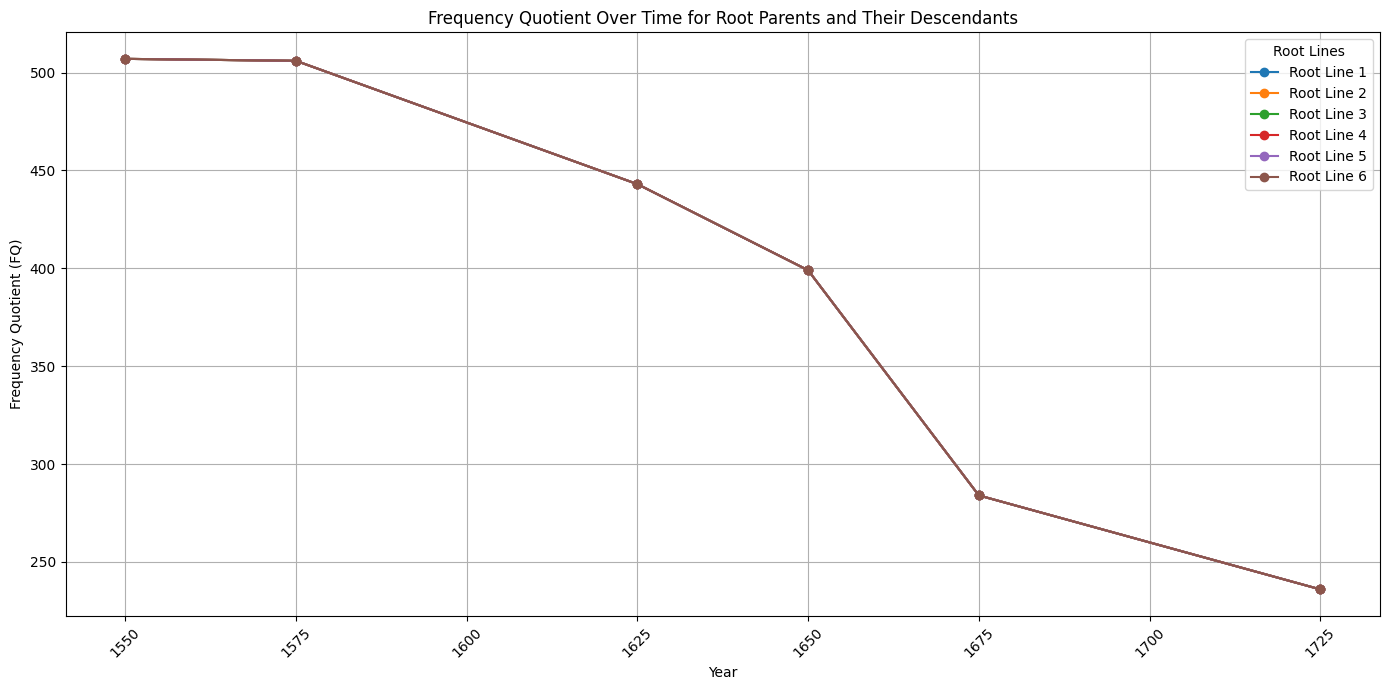

'/content/trailing_descendants.xlsx'

In [ ]:
#7 draft

import pandas as pd
import matplotlib.pyplot as plt
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side, Alignment, PatternFill, Font

# Load the provided root_parent_master_processed.xlsx file
root_parent_master_processed_path = '/content/root_parent_master_processed.xlsx'  # Update the path as needed
root_parent_master_processed_df = pd.read_excel(root_parent_master_processed_path)

# Load the root parents from the processed file into a dictionary
root_parent_master_updated = root_parent_master_processed_df.set_index('root_parent_master').T.to_dict()

# Count and print the full complement of root parent pairs
full_complement_count = len(root_parent_master_updated)
print(f"Full complement of root parent pairs: {full_complement_count}")

# Define the fq_threshold value
fq_threshold = 160  # Set this value as needed

print(f"The Frequency Quotient threshold is set to: {fq_threshold}")

def parse_ancestors(df):
    """Parse the Ancestors column to determine the first parent pair."""
    first_parents = []
    for index, row in df.iterrows():
        nodes = row['Ancestors'].split('~~~')
        if nodes:
            first_parent_pair = nodes[0]
            first_parents.append(first_parent_pair)
    return set(first_parents)

def process_data(df, root_parent_master):
    """Load data, process it to expand 'Ancestors', calculate FQ and QI, and return a dictionary of results."""
    first_parents = parse_ancestors(df)
    expanded_data = []
    for index, row in df.iterrows():
        nodes = row['Ancestors'].split('~~~')
        for i, node in enumerate(nodes):
            parent = nodes[i-1] if i > 0 else None
            expanded_data.append({
                'Parents': parent,
                'Offspring & Spouse': node,
                'cM': row['cM'],
                'ID': row.get('ID', '')  # Ensure ID is optionally included
            })
    expanded_df = pd.DataFrame(expanded_data)
    grouped_df = expanded_df.groupby(['Parents', 'Offspring & Spouse']).agg(
        FQ=('Offspring & Spouse', 'size'),
        cM_sum=('cM', 'sum')
    ).reset_index()
    grouped_df['DI'] = grouped_df['Parents'].apply(lambda x: x[:2] if pd.notnull(x) else '')
    grouped_df['QI'] = (grouped_df['cM_sum'] / grouped_df['FQ']).round().astype(int)
    grouped_df['Root'] = grouped_df.apply(lambda x: 'Yes' if x['Parents'] in root_parent_master else '', axis=1)
    grouped_df['Prefix'] = grouped_df['Parents'].str.extract(r'(\d+)')
    grouped_df['Prefix'] = grouped_df['Prefix'].astype(str)
    final_results_df = grouped_df[['Root', 'Parents', 'FQ', 'QI', 'Offspring & Spouse', 'Prefix', 'DI']]
    final_results_df = final_results_df[final_results_df['FQ'] >= fq_threshold].copy()
    return final_results_df, len(df)

# Load the provided data
input_file_path = '/content/DNA_Study_Library.xlsx'  # Update the path as needed
df = pd.read_excel(input_file_path)

# Process the data
processed_data_df, total_records = process_data(df, root_parent_master_updated)

def sort_all_segments(data_dict):
    """Sort all segments within the data based on the FQ in descending order."""
    df = pd.DataFrame(data_dict)
    sorted_df = df.groupby('Prefix', group_keys=False).apply(lambda x: x.sort_values(by='FQ', ascending=False)).reset_index(drop=True)
    return sorted_df

# Sort the data
sorted_data_df = sort_all_segments(processed_data_df.to_dict(orient='list'))

def assemble_descendants(df, total_records, fq_threshold):
    """Assemble descendants starting from root parents and include FQ, QI, and % Total."""
    assembled_data = []
    di_dict = {}  # Dictionary to store DI values for each ancestor

    for root, root_data in root_parent_master_updated.items():
        if root_data['FQ'] >= fq_threshold:
            di_dict[root] = root[:2]  # Store the DI value for the root
            current_generation = [(root, 0)]
            assembled_data.append({
                'Root': 'Yes',
                'Parents and Trailing Descendants': root,
                'FQ': root_data['FQ'],
                'QI': root_data['QI'],
                '% Total': f"{round(root_data['FQ'] / total_records * 100)}%",
                'DI': int(di_dict[root])  # Convert DI to integer
            })
            while current_generation:
                next_generation = []
                for parent, depth in current_generation:
                    children = df[df['Parents'] == parent]
                    for _, child_row in children.iterrows():
                        di = int(di_dict[parent]) if parent in di_dict else int(child_row['Parents'][:2])
                        fq = child_row['FQ']
                        qi = child_row['QI']
                        percent_total = f"{round(fq / total_records * 100)}%"
                        descendant = f"{'  ' * (depth + 1)}→ {child_row['Offspring & Spouse']}"
                        assembled_data.append({
                            'Root': '',
                            'Parents and Trailing Descendants': descendant,
                            'FQ': fq,
                            'QI': qi,
                            '% Total': percent_total,
                            'DI': di  # Convert DI to integer
                        })
                        next_generation.append((child_row['Offspring & Spouse'], depth + 1))
                        di_dict[child_row['Offspring & Spouse']] = di  # Propagate the DI value to the next generation
                current_generation = next_generation

    assembled_df = pd.DataFrame(assembled_data)
    assembled_df['DI'] = assembled_df['Parents and Trailing Descendants'].apply(lambda x: int(x.split('→')[-1].strip()[:2]))
    assembled_df['DI'] = assembled_df.apply(lambda row: int(row['DI']) if row['DI'] != '' else int(row['Parents and Trailing Descendants'][:2]), axis=1)
    assembled_df['FQ'] = assembled_df['FQ'].astype(int)
    assembled_df['QI'] = assembled_df['QI'].astype(int)
    return assembled_df

# Assemble descendants
descendants_df = assemble_descendants(pd.DataFrame(sorted_data_df), total_records, fq_threshold)

# Print the count of records each time
print(f"Total Records: {total_records}")
print(f"Filtered root parents count (FQ >= {fq_threshold}): {len(descendants_df[descendants_df['Root'] == 'Yes'])}")

# Output the entire DataFrame to the console
print(descendants_df.to_string(index=False))

# Save specified columns to a list
def save_columns_to_list(df, columns):
    data_list = df[columns].values.tolist()
    return data_list

# Specify columns to be saved
columns_to_save = ['Root', 'Parents and Trailing Descendants', 'FQ', 'DI']
graph_data = save_columns_to_list(descendants_df, columns_to_save)

# Print the data list for verification
print(graph_data)

def save_to_excel_with_styles(df, output_path):
    """Save the assembled data to an Excel file with the desired format and styles."""
    wb = Workbook()
    ws = wb.active
    headers = ['Root', 'Parents and Trailing Descendants', 'FQ', 'QI', '% Total', 'DI']
    ws.append(headers)
    header_alignment = Alignment(horizontal="center", vertical="center")
    header_font = Font(bold=True)
    thick = Side(border_style="thick", color="000000")
    for cell in ws[1]:
        cell.alignment = header_alignment
        cell.font = header_font
        cell.border = Border(top=thick, left=thick, right=thick, bottom=thick)
    for r in dataframe_to_rows(df, index=False, header=False):
        ws.append(r)
    thin = Side(border_style="thin", color="000000")
    center_alignment = Alignment(horizontal="center", vertical="center")
    left_alignment = Alignment(horizontal="left", vertical="center")
    col_indices = {'FQ': 3, 'QI': 4, '% Total': 5, 'DI': 6}
    for row in ws.iter_rows(min_row=2, max_col=len(headers), max_row=ws.max_row):
        for cell in row:
            cell.border = Border(top=thin, left=thin, right=thin, bottom=thin)
            if cell.column in col_indices.values():
                cell.border = Border(top=thin, left=thick, right=thick, bottom=thick)
                cell.alignment = center_alignment
            elif cell.column == 2:
                cell.alignment = left_alignment
    wb.save(output_path)
    print(f"Results successfully saved to {output_path}")

# Save the assembled data to an Excel file with styles
output_file_path = '/content/trailing_descendants.xlsx'  # Update the path as needed
save_to_excel_with_styles(descendants_df, output_file_path)

# Plotting the graph
interval_scheme = [
    (1000, 1), (1025, 2), (1050, 3), (1075, 4), (1100, 5),
    (1125, 6), (1150, 7), (1175, 8), (1200, 9), (1225, 10),
    (1250, 11), (1275, 12), (1300, 13), (1325, 14), (1350, 15),
    (1375, 16), (1400, 17), (1425, 18), (1450, 19), (1475, 20),
    (1500, 21), (1525, 22), (1550, 23), (1575, 24), (1600, 25),
    (1625, 26), (1650, 27), (1675, 28), (1700, 29), (1725, 30),
    (1750, 31), (1775, 32), (1800, 33), (1825, 34), (1850, 35),
    (1875, 36), (1900, 37), (1925, 38), (1950, 39), (1975, 40),
    (2000, 41), (2025, 42), (2050, 43), (2075, 44)
]

# Create a mapping for intervals to years
interval_to_year = {value: year for year, value in interval_scheme}

# Convert DI to integers for proper plotting
descendants_df['DI'] = descendants_df['DI'].astype(int)

# Plotting the data
fig, ax = plt.subplots(figsize=(14, 7))

for i, (root, *data) in enumerate(graph_data):
    years = [interval_to_year[di] for _, _, _, di in graph_data]
    fqs = [fq for _, _, fq, _ in graph_data]
    ax.plot(years, fqs, marker='o', label=f'Root Line {i+1}')

ax.set_title('Frequency Quotient Over Time for Root Parents and Their Descendants')
ax.set_xlabel('Year')
ax.set_ylabel('Frequency Quotient (FQ)')
ax.legend(title='Root Lines')

# Display the plot
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Verify the output Excel file
output_file_path



In [ ]:
# Section 7: Chart of First Parents and Sort Names

#makes_/content/1-data-firstp_list_matchnames.xlsx

import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'  # Update this path as necessary
df = pd.read_excel(file_path, usecols=["Sort", "cM", "First Pair"])

# Initialize a dictionary to store the results
results_dict = {}

# Set the frequency threshold
frequency_threshold = 1

# Function to validate cM calculations
def validate_cm_calculation(grouped_data, original_data):
    validation_results = []
    for sort_name in grouped_data['Sort'].unique():
        original_sum_cm = original_data[original_data['Sort'] == sort_name]['cM'].sum()
        calculated_sum_cm = grouped_data[grouped_data['Sort'] == sort_name]['Sum_cM'].values[0]
        validation_results.append((sort_name, original_sum_cm, calculated_sum_cm))
    return validation_results

# Calculate statistics for each unique 'First Pair'
unique_first_pairs = df['First Pair'].unique()

for first_pair in unique_first_pairs:
    fp_data = df[df['First Pair'] == first_pair]
    total_occurrences = fp_data['Sort'].count()

    # Aggregate the data by 'Sort' to handle duplicates
    name_stats = fp_data.groupby('Sort').agg({'cM': ['count', 'sum']}).reset_index()
    name_stats.columns = ['Sort', 'FQ', 'Sum_cM']
    name_stats['Mean_cM'] = (name_stats['Sum_cM'] / name_stats['FQ']).round().astype(int)
    name_stats['Percentage'] = (name_stats['FQ'] / total_occurrences * 100).round().astype(int)

    # Validate cM calculations
    validation_results = validate_cm_calculation(name_stats, fp_data)
    for sort_name, original_sum, calculated_sum in validation_results:
        if original_sum != calculated_sum:
            print(f"Validation Error: {sort_name} has mismatched cM values. Original: {original_sum}, Calculated: {calculated_sum}")

    # Filter based on the frequency threshold
    name_stats = name_stats[name_stats['FQ'] > frequency_threshold]

    # Sort the results by FQ
    name_stats_sorted = name_stats.sort_values(by='FQ', ascending=False)

    # Store the results in the dictionary
    results_dict[first_pair] = name_stats_sorted

# Create a new workbook and select the active worksheet
wb = Workbook()
ws = wb.active

# Define the header format
headers = ["Root", "First Pairs", "FQ", "QI", "% Total"]
ws.append(headers)

# Apply header formatting
header_font = Font(bold=True)
center_alignment = Alignment(horizontal="center")

for col in range(1, len(headers) + 1):
    ws.cell(row=1, column=col).font = header_font
    ws.cell(row=1, column=col).alignment = center_alignment

# Add the data to the worksheet
current_first_pair = None
row_index = 2
for first_pair, stats in results_dict.items():
    if not stats.empty:
        ws.append(["", "", "", "", ""])  # Add a blank line before each new First Pair grouping
        total_fq = stats['FQ'].sum()
        total_percentage = 100  # Since it's the whole group, it's 100%
        ws.append(["Yes", first_pair, total_fq, "", f"{total_percentage}%"])
        for col in range(1, len(headers) + 1):
            ws.cell(row=row_index, column=col).alignment = center_alignment
        row_index += 1

        for _, row in stats.iterrows():
            sort_name = row['Sort']
            fq = row['FQ']
            mean_cm = row['Mean_cM']
            percentage = row['Percentage']
            ws.append(["", f"→ {sort_name}", fq, mean_cm, f"{percentage}%"])
            for col in range(1, len(headers) + 1):
                ws.cell(row=row_index, column=col).alignment = center_alignment
            row_index += 1

# Save the workbook
output_path = '/content/1-data-firstp_list_matchnames.xlsx'
wb.save(output_path)

output_path

# Section 7: Chart of First Parents and Sort Names

'/content/1-data-firstp_list_matchnames.xlsx'

In [ ]:
# Section 8: Chart of Sort Name and First Parents

# makes_/content/2-data-matchnames_list_firstp_.xlsx

import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'
df = pd.read_excel(file_path, usecols=["Sort", "cM", "First Pair"])

# Group the data by "Sort" name and "First Pair"
grouped = df.groupby(['Sort', 'First Pair']).agg({'cM': ['count', 'mean']}).reset_index()
grouped.columns = ['Sort', 'First Pair', 'FQ', 'Mean_cM']

# Create a new workbook and select the active worksheet
wb = Workbook()
ws = wb.active

# Apply header formatting
headers = ["Sort Name", "First Pair", "FQ", "Mean cM", "%"]
ws.append(headers)

header_font = Font(bold=True)
center_alignment = Alignment(horizontal="center")

for col in range(1, len(headers) + 1):
    ws.cell(row=1, column=col).font = header_font
    ws.cell(row=1, column=col).alignment = center_alignment

# Add the data to the worksheet
current_sort_name = None
row_index = 2

for sort_name in grouped['Sort'].unique():
    current_group = grouped[grouped['Sort'] == sort_name]
    total_fq = current_group['FQ'].sum()

    ws.append([sort_name, "", "", "", ""])
    row_index += 1

    for _, row in current_group.iterrows():
        first_pair = row['First Pair']
        fq = row['FQ']
        mean_cm = row['Mean_cM']
        percentage = (fq / total_fq) * 100
        ws.append(["", first_pair, fq, round(mean_cm), f"{round(percentage)}%"])
        for col in range(1, len(headers) + 1):
            ws.cell(row=row_index, column=col).alignment = center_alignment
        row_index += 1

# Save the workbook
output_path = '/content/2-data-matchnames_list_firstp_.xlsx'
wb.save(output_path)

output_path
# Section 8: Chart of Sort Name and First Parents

'/content/2-data-matchnames_list_firstp_.xlsx'

In [ ]:
# Section 9: Matrix-2_Sort Name and First Parents

import pandas as pd

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'  # Update the path if necessary
df = pd.read_excel(file_path, usecols=["Sort", "cM", "First Pair"])

# Group the data by "Sort" name and "First Pair" and calculate the FQ
grouped = df.groupby(['Sort', 'First Pair']).agg({'cM': 'count'}).reset_index()
grouped.columns = ['Sort', 'First Pair', 'FQ']

# Create a pivot table with 'First Pair' as rows and 'Sort' as columns
pivot_table = grouped.pivot(index='First Pair', columns='Sort', values='FQ').fillna(0)

# Add summaries for rows and columns
pivot_table['Total FQ'] = pivot_table.sum(axis=1)
pivot_table.loc['Total FQ Summary'] = pivot_table.sum(axis=0)

# Apply the first limitation: filter the pivot table to only include 'First Pair' rows with 'Total FQ' >= 2
pivot_table_first_limit = pivot_table[pivot_table['Total FQ'] >= 2]

# Sort the pivot table by 'Total FQ' in descending order
pivot_table_first_limit_sorted = pivot_table_first_limit.sort_values(by='Total FQ', ascending=False)

# Save the first iteration to a dictionary
first_iteration_dict = pivot_table_first_limit_sorted.to_dict()

# Apply the second limitation: filter the pivot table to only include 'Sort Name' columns with 'Total FQ' >= 4
column_sums = pivot_table_first_limit_sorted.loc['Total FQ Summary']
filtered_columns = column_sums[column_sums >= 4].index.tolist()

# Specify certain "Sort Name" columns not to display
exclude_columns = ['milocan', 'addison,david', 'zimkat', 'adamssarah', 'yates,nancy', 'walclif', 'mccollummike']
filtered_columns = [col for col in filtered_columns if col not in exclude_columns]

# Ensure 'Total FQ' is the last column after sorting columns
pivot_table_second_limit = pivot_table_first_limit_sorted[filtered_columns + ['Total FQ']]
column_sums = pivot_table_second_limit.loc['Total FQ Summary'].sort_values(ascending=False)
sorted_columns = column_sums.index.tolist()
sorted_columns.remove('Total FQ')
pivot_table_final = pivot_table_second_limit[sorted_columns + ['Total FQ']]

# Print the final sorted pivot table with summaries
print("Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):")
print(pivot_table_final.to_string())

# Section 9: Matrix-2_Sort Name and First Parents


Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):
Sort                                             Total FQ  Total FQ  yates,ronald  marmar  wishardglen  yates,patricial  klingal  yates,timothyb  fridine  weeksjerri  yatesjamesrob  girtain,alma  birdwelljac  yates,andreal  cagilaba,leigh  yates,johnh  hendricksjas  littleil  girtain,kathryn  girtain,andy  cherylod  yates,timothyj  stetlerkar  leedon  harper,mable  yates,robertd  evansdei  franch,mike  henryche  girtain,theresa  yatesjohnh  solyons  girtja  yatesjohnrob  Total FQ  Total FQ
First Pair                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'  # Update the path if necessary
df = pd.read_excel(file_path, usecols=["Sort", "cM", "First Pair"])

# Group the data by "Sort" name and "First Pair" and calculate the FQ
grouped = df.groupby(['Sort', 'First Pair']).agg({'cM': 'count'}).reset_index()
grouped.columns = ['Sort', 'First Pair', 'FQ']

# Create a pivot table with 'First Pair' as rows and 'Sort' as columns
pivot_table = grouped.pivot(index='First Pair', columns='Sort', values='FQ').fillna(0)

# Add summaries for rows and columns
pivot_table['Total FQ'] = pivot_table.sum(axis=1)
pivot_table.loc['Total FQ Summary'] = pivot_table.sum(axis=0)

# Apply the first limitation: filter the pivot table to only include 'First Pair' rows with 'Total FQ' >= 2
pivot_table_first_limit = pivot_table[pivot_table['Total FQ'] >= 2]

# Sort the pivot table by 'Total FQ' in descending order
pivot_table_first_limit_sorted = pivot_table_first_limit.sort_values(by='Total FQ', ascending=False)

# Save the first iteration to a dictionary
first_iteration_dict = pivot_table_first_limit_sorted.to_dict()

# Apply the second limitation: filter the pivot table to only include 'Sort Name' columns with 'Total FQ' >= 4
column_sums = pivot_table_first_limit_sorted.loc['Total FQ Summary']
filtered_columns = column_sums[column_sums >= 4].index.tolist()

# Specify certain "Sort Name" columns not to display
exclude_columns = ['milocan', 'addison,david', 'zimkat', 'adamssarah', 'yates,nancy', 'walclif', 'mccollummike']
filtered_columns = [col for col in filtered_columns if col not in exclude_columns]

# Ensure 'Total FQ' is the last column after sorting columns
pivot_table_second_limit = pivot_table_first_limit_sorted[filtered_columns + ['Total FQ']]
column_sums = pivot_table_second_limit.loc['Total FQ Summary'].sort_values(ascending=False)
sorted_columns = column_sums.index.tolist()
sorted_columns.remove('Total FQ')
pivot_table_final = pivot_table_second_limit[sorted_columns + ['Total FQ']]

# Print the final sorted pivot table with summaries
print("Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):")
print(pivot_table_final.to_string())

# Save the final result to an Excel file with formatting
output_path = '/content/Matrix-2_Sort Name and First Parents.xlsx'

# Create a new workbook and select the active worksheet
wb = Workbook()
ws = wb.active

# Apply header formatting
headers = ["First Pair"] + sorted_columns + ["Total FQ"]
ws.append(headers)

header_font = Font(bold=True)
center_alignment = Alignment(horizontal="center")

for col in range(1, len(headers) + 1):
    ws.cell(row=1, column=col).font = header_font
    ws.cell(row=1, column=col).alignment = center_alignment

# Add the data to the worksheet
for row in pivot_table_final.itertuples():
    ws.append([row.Index] + list(row[1:]))

for row in ws.iter_rows(min_row=2, max_col=ws.max_column, max_row=ws.max_row):
    for cell in row:
        cell.alignment = center_alignment

# Save the workbook
wb.save(output_path)

# Output the path for download
print(f"Saved the final result to {output_path}")


Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):
Sort                                             Total FQ  Total FQ  yates,ronald  marmar  wishardglen  yates,patricial  klingal  yates,timothyb  fridine  weeksjerri  yatesjamesrob  girtain,alma  birdwelljac  yates,andreal  cagilaba,leigh  yates,johnh  hendricksjas  littleil  girtain,kathryn  girtain,andy  cherylod  yates,timothyj  stetlerkar  leedon  harper,mable  yates,robertd  evansdei  franch,mike  henryche  girtain,theresa  yatesjohnh  solyons  girtja  yatesjohnrob  Total FQ  Total FQ
First Pair                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'  # Update the path if necessary
df = pd.read_excel(file_path, usecols=["Sort", "cM", "First Pair"])

# Group the data by "Sort" name and "First Pair" and calculate the FQ
grouped = df.groupby(['Sort', 'First Pair']).agg({'cM': 'count'}).reset_index()
grouped.columns = ['Sort', 'First Pair', 'FQ']

# Create a pivot table with 'First Pair' as rows and 'Sort' as columns
pivot_table = grouped.pivot(index='First Pair', columns='Sort', values='FQ').fillna(0)

# Add summaries for rows and columns
pivot_table['Total FQ'] = pivot_table.sum(axis=1)
pivot_table.loc['Total FQ Summary'] = pivot_table.sum(axis=0)

# Apply the first limitation: filter the pivot table to only include 'First Pair' rows with 'Total FQ' >= 2
pivot_table_first_limit = pivot_table[pivot_table['Total FQ'] >= 2]

# Sort the pivot table by 'Total FQ' in descending order
pivot_table_first_limit_sorted = pivot_table_first_limit.sort_values(by='Total FQ', ascending=False)

# Save the first iteration to a dictionary
first_iteration_dict = pivot_table_first_limit_sorted.to_dict()

# Apply the second limitation: filter the pivot table to only include 'Sort Name' columns with 'Total FQ' >= 4
column_sums = pivot_table_first_limit_sorted.loc['Total FQ Summary']
filtered_columns = column_sums[column_sums >= 4].index.tolist()

# Specify certain "Sort Name" columns not to display
exclude_columns = ['milocan', 'addison,david', 'zimkat', 'adamssarah', 'yates,nancy', 'walclif', 'mccollummike']
filtered_columns = [col for col in filtered_columns if col not in exclude_columns]

# Ensure 'Total FQ' is the last column after sorting columns
pivot_table_second_limit = pivot_table_first_limit_sorted[filtered_columns + ['Total FQ']]
column_sums = pivot_table_second_limit.loc['Total FQ Summary'].sort_values(ascending=False)
sorted_columns = column_sums.index.tolist()
sorted_columns.remove('Total FQ')
pivot_table_final = pivot_table_second_limit[sorted_columns + ['Total FQ']]

# Print the final sorted pivot table with summaries
print("Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):")
print(pivot_table_final.to_string())

# Save the final result to an Excel file with formatting
output_path = '/content/Matrix-2_Sort Name and First Parents.xlsx'

# Create a new workbook and select the active worksheet
wb = Workbook()
ws = wb.active

# Apply header formatting
headers = ["First Pair"] + sorted_columns + ["Total FQ"]
ws.append(headers)

header_font = Font(bold=True)
center_alignment = Alignment(horizontal="center")

for col in range(1, len(headers) + 1):
    ws.cell(row=1, column=col).font = header_font
    ws.cell(row=1, column=col).alignment = center_alignment

# Add the data to the worksheet
for row in pivot_table_final.itertuples():
    ws.append([row.Index] + list(row[1:]))

for row in ws.iter_rows(min_row=2, max_col=ws.max_column, max_row=ws.max_row):
    for cell in row:
        cell.alignment = center_alignment

# Save the workbook
wb.save(output_path)

# Output the path for download
print(f"Saved the final result to {output_path}")


Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):
Sort                                             Total FQ  Total FQ  yates,ronald  marmar  wishardglen  yates,patricial  klingal  yates,timothyb  fridine  weeksjerri  yatesjamesrob  girtain,alma  birdwelljac  yates,andreal  cagilaba,leigh  yates,johnh  hendricksjas  littleil  girtain,kathryn  girtain,andy  cherylod  yates,timothyj  stetlerkar  leedon  harper,mable  yates,robertd  evansdei  franch,mike  henryche  girtain,theresa  yatesjohnh  solyons  girtja  yatesjohnrob  Total FQ  Total FQ
First Pair                                                                                                                                                                                                                                                                                                                                                                                                         

In [ ]:
# Section 10: Matrix-2_Sort Name and First Parents.xlsx

import pandas as pd
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'  # Update the path if necessary
df = pd.read_excel(file_path, usecols=["Sort", "cM", "First Pair"])

# Group the data by "Sort" name and "First Pair" and calculate the FQ
grouped = df.groupby(['Sort', 'First Pair']).agg({'cM': 'count'}).reset_index()
grouped.columns = ['Sort', 'First Pair', 'FQ']

# Create a pivot table with 'First Pair' as rows and 'Sort' as columns
pivot_table = grouped.pivot(index='First Pair', columns='Sort', values='FQ').fillna(0)

# Add summaries for rows and columns
pivot_table['Total FQ'] = pivot_table.sum(axis=1)
pivot_table.loc['Total FQ Summary'] = pivot_table.sum(axis=0)

# Apply the first limitation: filter the pivot table to only include 'First Pair' rows with 'Total FQ' >= 2
pivot_table_first_limit = pivot_table[pivot_table['Total FQ'] >= 2]

# Sort the pivot table by 'Total FQ' in descending order
pivot_table_first_limit_sorted = pivot_table_first_limit.sort_values(by='Total FQ', ascending=False)

# Save the first iteration to a dictionary
first_iteration_dict = pivot_table_first_limit_sorted.to_dict()

# Apply the second limitation: filter the pivot table to only include 'Sort Name' columns with 'Total FQ' >= 4
column_sums = pivot_table_first_limit_sorted.loc['Total FQ Summary']
filtered_columns = column_sums[column_sums >= 4].index.tolist()

# Specify certain "Sort Name" columns not to display
exclude_columns = ['milocan', 'addison,david', 'zimkat', 'adamssarah', 'yates,nancy', 'walclif', 'mccollummike']
filtered_columns = [col for col in filtered_columns if col not in exclude_columns]

# Ensure 'Total FQ' is the last column after sorting columns
pivot_table_second_limit = pivot_table_first_limit_sorted[filtered_columns + ['Total FQ']]
pivot_table_final = pivot_table_second_limit.drop('Total FQ Summary', axis=0)

# Print the final sorted pivot table with summaries
print("Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):")
print(pivot_table_final.to_string())

# Save the final result to an Excel file with formatting
output_path = '/content/Matrix-2_Sort Name and First Parents.xlsx'
pivot_table_final.to_excel(output_path)

print("Final output saved successfully at:", output_path)

# Section 10: Matrix-2_Sort Name and First Parents.xlsx

Final Sorted Pivot Table with Summaries (FQ >= 2 and Sort Name FQ >= 4, Excluding Specified Columns):
Sort                                             birdwelljac  cagilaba,leigh  cherylod  evansdei  franch,mike  fridine  girtain,alma  girtain,andy  girtain,kathryn  girtain,theresa  girtja  harper,mable  hendricksjas  henryche  klingal  leedon  littleil  marmar  solyons  stetlerkar  weeksjerri  wishardglen  yates,andreal  yates,johnh  yates,patricial  yates,robertd  yates,ronald  yates,timothyb  yates,timothyj  yatesjamesrob  yatesjohnh  yatesjohnrob  Total FQ  Total FQ
First Pair                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
import pandas as pd
from openpyxl import Workbook

# Load the data from the provided Excel file
file_path = '/content/DNA_Study_Library.xlsx'  # Update the path if necessary
df = pd.read_excel(file_path, usecols=["Sort", "cM", "First Pair"])

# Group the data by "Sort" name and "First Pair" and calculate the FQ
grouped = df.groupby(['Sort', 'First Pair']).agg({'cM': 'count'}).reset_index()
grouped.columns = ['Sort', 'First Pair', 'FQ']

# Create a pivot table with 'First Pair' as rows and 'Sort' as columns
pivot_table = grouped.pivot(index='First Pair', columns='Sort', values='FQ').fillna(0)

# Add summaries for rows and columns
pivot_table['Total FQ'] = pivot_table.sum(axis=1)
pivot_table.loc['Total FQ Summary'] = pivot_table.sum(axis=0)

# Apply the first limitation: filter the pivot table to only include 'First Pair' rows with 'Total FQ' >= 2
pivot_table_first_limit = pivot_table[pivot_table['Total FQ'] >= 2]

# Sort the pivot table by 'Total FQ' in descending order
pivot_table_first_limit_sorted = pivot_table_first_limit.sort_values(by='Total FQ', ascending=False)

# Save the first iteration to a dictionary
first_iteration_dict = pivot_table_first_limit_sorted.to_dict()

# Apply the second limitation: filter the pivot table to only include 'Sort Name' columns with 'Total FQ' >= 4
column_sums = pivot_table_first_limit_sorted.loc['Total FQ Summary']
filtered_columns = column_sums[column_sums >= 4].index.tolist()

# Specify certain "Sort Name" columns not to display
exclude_columns = ['milocan', 'addison,david', 'zimkat', 'adamssarah', 'yates,nancy', 'walclif', 'mccollummike']
filtered_columns = [col for col in filtered_columns if col not in exclude_columns]

# Ensure 'Total FQ' is the last column after sorting columns
pivot_table_second_limit = pivot_table_first_limit_sorted[filtered_columns + ['Total FQ']]
pivot_table_final = pivot_table_second_limit.drop('Total FQ Summary', axis=0)

# Calculate percentages for the second sheet
percentage_pivot_table = pivot_table_final.div(pivot_table_final.sum(axis=0), axis=1) * 100

# Save the final result to an Excel file with two sheets: one for the original values and one for the percentages
output_path = '/content/Matrix-2_Sort_Name_and_First_Parents.xlsx'
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    pivot_table_final.to_excel(writer, sheet_name='FQ Values')
    percentage_pivot_table.to_excel(writer, sheet_name='Percentage Values')

print("Final output saved successfully at:", output_path)


Final output saved successfully at: /content/Matrix-2_Sort_Name_and_First_Parents.xlsx


In [ ]:
# Standard distribution compared to actual

import pandas as pd

# List of unique first pairs
first_pairs = [
    "23YatesFrancis&23TichborneJane", "30YatesBenjamin&42SearchingStill",
    "24YatesJohnThomas&24HatfieldeElizabeth", "31YatesAbraham&42SearchingStill",
    "32YatesJames&33SanfordSarah", "31YatesJohn&31BarfieldElizabeth",
    "33YatesWilliam&34ParkerSally", "27YatesWilliam&27BondMargaretCatherine",
    "30YatesWilliam&30ThornburyAnne", "26YatesJohn&27StrattonUrslyMehitable",
    "28YatesThomas&28DruryMonica", "32YatesJoseph&32LeighMary",
    "33YatesWilliam&33EdwardsElizabeth", "31RoperJamesDavid&31YatesSarahAnn",
    "30YatesJohn&30BoswellAnn", "32YatesJoseph&32AtmarSarah",
    "29YatesThomas&42SearchingStill", "29YatesJames&30McNayJane",
    "42YatesPhillip&42SearchingStill", "34ShepherdJonathan&34YatesEmilyBetty",
    "35YatesJohnWesley&35EvansAnn", "26YatesJohn&27StrattonMary",
    "32YatesJoshuaHardy&32StewartMarthaAnn", "29YatesMartin&42Eliz",
    "29PhillipsWilliam&29YatesAnn", "29YatesRichard&42Mary",
    "34YatesWilliam&34PikeEsther", "34YatesSamuelPorter&35BridgesMartha",
    "33YatesWilliam&33SaltPhoebe", "32SwiftAbsalom&33YatesMaryElizabeth",
    "32YatesJohnPryor&33MartinSarah", "36YatesHarryGeorge&37SheldonGraceAmy",
    "32YatesWilliam&33NeedhamMary", "32YatesJacob&32VandenberghElizabeth",
    "42YatesJoseph&42MaghullHelen", "42YatesNathanJames&42SearchingStill",
    "35YatesJames&36SuydamIsobelleElizabeth", "35YatesEdwardSamuel&35KirkpatrickSarahElizabeth",
    "34YatesWilliamPrice&34McKinneyElizabethAnn", "34YatesWilliamBasil&34BullockMartha",
    "34YatesDarlingBarber&34OliverMaryEmily", "34YatesThomas&34EvansMary",
    "34YatesSoloman&34McCammackElizabeth", "32YatesJames&33FlournoyMaryAnn",
    "33YatesWilliamThomas&33ShelhorseMaryPolly", "31HandJonathan&31YatesRebecca",
    "33YatesJohn&42SearchingStill", "33TolerElishaPhilpot&33YatesElizabeth",
    "33GirtainJonathon&33BarberRebecca", "33CowdenWilliam&33YatesCatherine",
    "32YatesHenry&32McManusNancy", "32YatesLoyd&32BrasfieldMaryPolly"
]

# Actual FQ values
actual_fq_values = [
    40, 57, 3, 0, 3, 2, 0, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
    0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
    0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0
]

# Total FQ for Yates, Ronald
total_fq_ronald = 121

# Calculate the expected FQ per first pair
expected_fq_per_pair = total_fq_ronald / len(first_pairs)

# Create a DataFrame to display the expected and actual FQ distribution
distribution_df = pd.DataFrame({
    'First Pair': first_pairs,
    'Expected FQ': [expected_fq_per_pair] * len(first_pairs),
    'Actual FQ': actual_fq_values
})

print(distribution_df)
# Standard distribution compared to actual

                                         First Pair  Expected FQ  Actual FQ
0                    23YatesFrancis&23TichborneJane     2.326923         40
1                  30YatesBenjamin&42SearchingStill     2.326923         57
2            24YatesJohnThomas&24HatfieldeElizabeth     2.326923          3
3                   31YatesAbraham&42SearchingStill     2.326923          0
4                       32YatesJames&33SanfordSarah     2.326923          3
5                   31YatesJohn&31BarfieldElizabeth     2.326923          2
6                      33YatesWilliam&34ParkerSally     2.326923          0
7            27YatesWilliam&27BondMargaretCatherine     2.326923          2
8                    30YatesWilliam&30ThornburyAnne     2.326923          2
9              26YatesJohn&27StrattonUrslyMehitable     2.326923          0
10                      28YatesThomas&28DruryMonica     2.326923          0
11                        32YatesJoseph&32LeighMary     2.326923          0
12          

In [ ]:
# Section 11-31YatesAbraham&42SearchingStill

import pandas as pd

# Load the data from the provided Excel file
file_path = '/content/Matrix-2_Sort_Name_and_First_Parents-abraham.xlsx'
df = pd.read_excel(file_path, sheet_name='FQ Values', index_col=0)

# Display the first few rows of the DataFrame to confirm the structure
print(df.head())

# Calculate the total FQ for the New Jersey group using the correct column name
total_fq_nj = df['NJ-FQ'].sum()

# Identify the FQ values for "23YatesFrancis&23TichborneJane" and "31YatesAbraham&42SearchingStill"
fq_yatesfrancis = df.at['23YatesFrancis&23TichborneJane', 'NJ-FQ']
fq_abraham = df.at['31YatesAbraham&42SearchingStill', 'NJ-FQ']

# Calculate their combined FQ and percentage of the total FQ
combined_fq = fq_yatesfrancis + fq_abraham
combined_percentage = (combined_fq / total_fq_nj) * 100

# Calculate the balance FQ and its percentage
balance_fq = total_fq_nj - combined_fq
balance_percentage = (balance_fq / total_fq_nj) * 100

# Output the results
print(f"Total FQ for New Jersey group: {total_fq_nj}")
print(f"FQ for 23YatesFrancis&23TichborneJane: {fq_yatesfrancis}")
print(f"FQ for 31YatesAbraham&42SearchingStill: {fq_abraham}")
print(f"Combined FQ: {combined_fq}")
print(f"Combined Percentage: {combined_percentage:.2f}%")
print(f"Balance FQ: {balance_fq}")
print(f"Balance Percentage: {balance_percentage:.2f}%")

# Check if the pattern is consistent with the Benjamin Yates scenario
benjamin_yates_fq = df.at['30YatesBenjamin&42SearchingStill', 'NJ-FQ']
benjamin_percentage = (benjamin_yates_fq / total_fq_nj) * 100
print(f"FQ for 30YatesBenjamin&42SearchingStill: {benjamin_yates_fq}")
print(f"Benjamin Yates Percentage: {benjamin_percentage:.2f}%")

# Section 11-31YatesAbraham&42SearchingStill

                                        girtain,alma  girtain,andy  \
First Pair                                                           
23YatesFrancis&23TichborneJane                  12.0          10.0   
30YatesBenjamin&42SearchingStill                 0.0           0.0   
24YatesJohnThomas&24HatfieldeElizabeth           2.0           3.0   
31YatesAbraham&42SearchingStill                  9.0           2.0   
32YatesJames&33SanfordSarah                      0.0           0.0   

                                        girtain,kathryn  girtain,theresa  \
First Pair                                                                 
23YatesFrancis&23TichborneJane                     11.0              5.0   
30YatesBenjamin&42SearchingStill                    1.0              1.0   
24YatesJohnThomas&24HatfieldeElizabeth              0.0              1.0   
31YatesAbraham&42SearchingStill                     3.0              0.0   
32YatesJames&33SanfordSarah                         0

Summary statistics for key peaks:
 count     2.000000
mean     48.500000
std      12.020815
min      40.000000
25%      44.250000
50%      48.500000
75%      52.750000
max      57.000000
Name: Actual FQ, dtype: float64
Summary statistics for rest of the data:
 count    50.000000
mean      0.420000
std       0.810392
min       0.000000
25%       0.000000
50%       0.000000
75%       0.750000
max       3.000000
Name: Actual FQ, dtype: float64


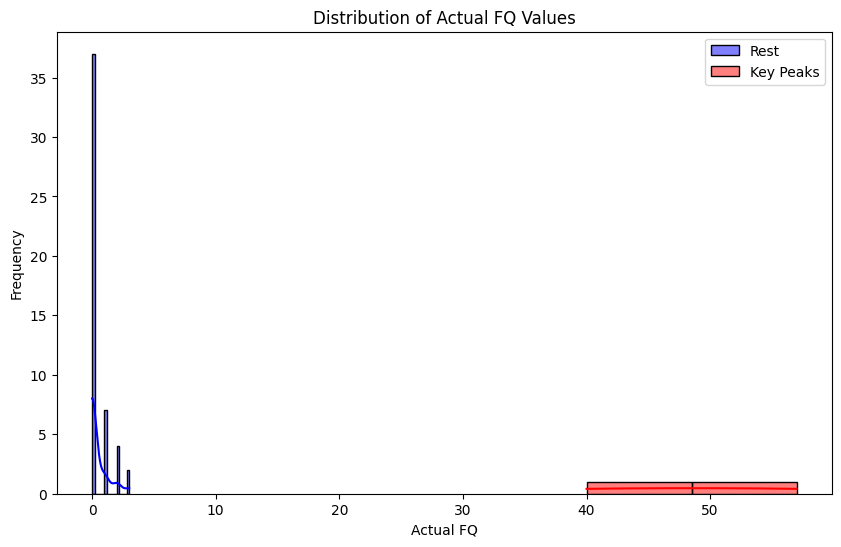

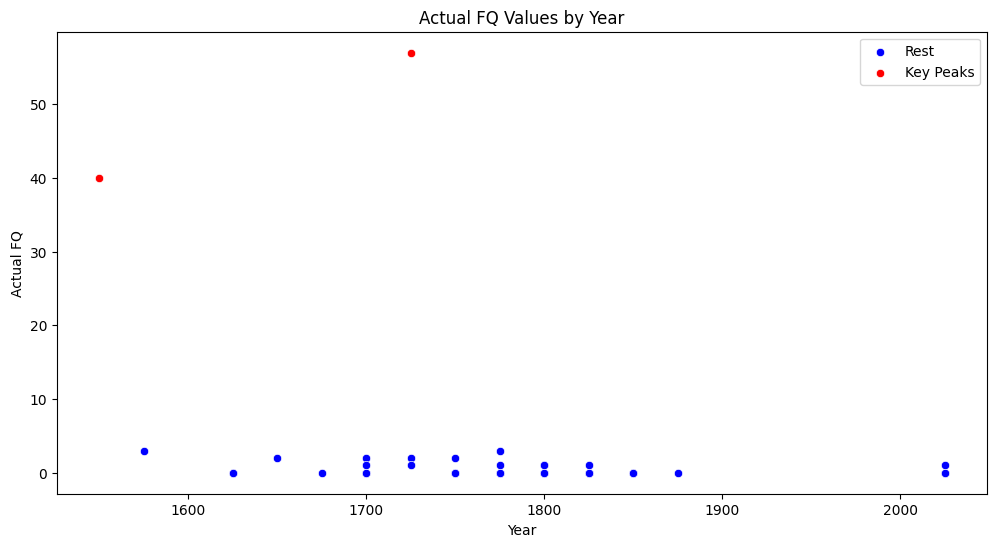

Variance of Actual FQ Values (Key Peaks): 72.25
Variance of Actual FQ Values (Rest): 0.6436000000000002


In [ ]:
# Summary statistics for key peaks and rest of the data
summary_stats_peaks = key_peaks['Actual FQ'].describe()
summary_stats_rest = rest['Actual FQ'].describe()
print("Summary statistics for key peaks:\n", summary_stats_peaks)
print("Summary statistics for rest of the data:\n", summary_stats_rest)

# Plot the distribution of FQ values
plt.figure(figsize=(10, 6))
sns.histplot(rest['Actual FQ'], kde=True, bins=15, color='blue', label='Rest')
sns.histplot(key_peaks['Actual FQ'], kde=True, bins=2, color='red', label='Key Peaks')
plt.legend()
plt.title('Distribution of Actual FQ Values')
plt.xlabel('Actual FQ')
plt.ylabel('Frequency')
plt.show()

# Plot the years vs. FQ values to see if there's any trend
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Year', y='Actual FQ', data=rest, color='blue', label='Rest')
sns.scatterplot(x='Year', y='Actual FQ', data=key_peaks, color='red', label='Key Peaks')
plt.legend()
plt.title('Actual FQ Values by Year')
plt.xlabel('Year')
plt.ylabel('Actual FQ')
plt.show()

# Calculate variance for each group
variance_peaks = np.var(key_peaks['Actual FQ'])
variance_rest = np.var(rest['Actual FQ'])
print(f'Variance of Actual FQ Values (Key Peaks): {variance_peaks}')
print(f'Variance of Actual FQ Values (Rest): {variance_rest}')

#  Good Data Validation